# Project description
In the US alone, restaurants waste 25bn pounds of food every year before it reaches the consumers plate and independent restaurants are a large driver of this. This is crucial for an industry that operates with very low profit margins of 3% to 6% on average. In this project we have partnered with Burnt (https://burnt.squarespace.com), whose mission is to help restaurants automate their back-of-house operational flow: recipe management, inventory forecasting, analysis and optimization of costs. In this project, we will use time series data from restaurants to forecast menu item sales based on different factors such as day of the week, weather, holidays etc., which will help to optimize ordering decisions for maximum efficiency.

Evaristo Villaseco Arribas, Davood B. Dar

Stakeholders
- Restaurants
- Burnt
- Investors
- Consumers

KPIs:
- Accuracy of sales forecasting

In [24]:
# importing the packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
from datetime import datetime
from meteostat import Point, Hourly
import warnings
import holidays
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose


# Project Timeline

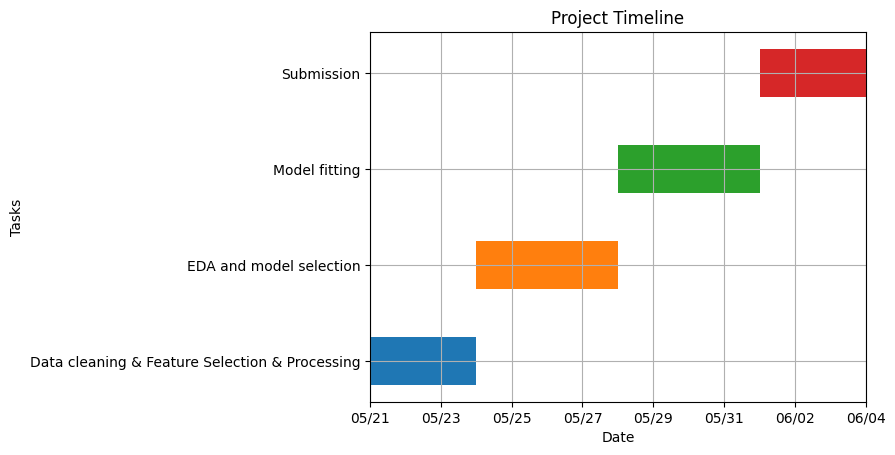

In [1]:



# Step 2: Create the data for the Gantt chart
tasks = ['Data cleaning & Feature Selection & Processing', 'EDA and model selection', 'Model fitting', 'Submission']
start_dates = ['2024-05-21', '2024-05-24', '2024-05-28', '2024-06-01']
durations = [3, 4, 4, 3]

# Step 3: Initialize the figure and axis
fig, ax = plt.subplots()

# Step 4: Set y-axis tick labels
ax.set_yticks(np.arange(len(tasks)))
ax.set_yticklabels(tasks)

# Step 5: Plot each task as a horizontal bar
for i in range(len(tasks)):
    start_date = pd.to_datetime(start_dates[i])
    end_date = start_date + pd.DateOffset(days=durations[i])
    ax.barh(i, end_date - start_date, left=start_date, height=0.5, align='center')

# Step 6: Set x-axis limits
min_date = pd.to_datetime(min(start_dates))
max_date = pd.to_datetime(max(start_dates)) + pd.DateOffset(days=min(durations))
ax.set_xlim(min_date, max_date)

# Step 7: Customize the chart
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
ax.set_xlabel('Date')
ax.set_ylabel('Tasks')
ax.set_title('Project Timeline')

# Step 8: Display the chart
plt.grid(True)
plt.show()

# Data loading and pre-processing

In [3]:
df=pd.read_csv('sales-output-new-7.csv')
df.head()

,Item Id,Item Name,Date,Category_id,Quantity,Price
0,e81e5e13-02d0-4cd2-bf20-220b0be0d6c9,Pane Frattau,2022-10-01T11:08:21,30d04694-ff34-4166-9d97-1a92950c3e73,1,15.00
1,597736fa-94ed-4cac-898f-399db9459a64,Omelette,2022-10-01T11:08:21,d3e202ef-e7f4-4cc9-a439-14b8baf9c6e0,1,14.00
2,2b4bca80-906f-4c64-87bd-e1c96562636b,Lemon Ricotta Pancakes,2022-10-01T11:08:21,d3e202ef-e7f4-4cc9-a439-14b8baf9c6e0,1,13.00
3,015df0d2-727e-415a-89fc-315205ff38c3,Mimosa,2022-10-01T11:08:21,8b1e2431-d1bd-4d68-be97-fd018d94fcf0,1,13.00
4,e01b529a-d845-4bc9-8984-9fdd19b1e817,Non-Cash ADJ,2022-10-01T11:08:03,089655cd-eba5-435a-8472-b4a0e2508561,1,2.21


In [4]:
df=pd.read_csv('sales-output-new-7.csv')

#First we remove spaces in the labels of columns
df.columns=df.columns.str.strip()

# We identify that some columns have missing seconds
print(df['Date'].iloc[170])
print(df['Date'].iloc[169])
print(df['Date'].iloc[183])

# use format for dates
# for the entries that fails to parse and is NaT parses them in the second format without seconds
#df['Date']=pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M:%S', errors='coerce').fillna(
#    pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M', errors='coerce'))
df['Date']=pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M:%S', errors='coerce').fillna(pd.to_datetime(df['Date'], format='%Y-%m-%dT%H:%M', errors='coerce')).dt.floor('h')

# We remove spaces and get all the unique categories
df['Item Name']=df['Item Name'].str.strip()
categories=df['Item Name'].unique()

# We remove 'NO make - KITCHEN') and 'No make BAR' categories
remove=['NO make - KITCHEN','NO make BAR']
categories = [item for item in categories if item not in remove]

# First we make a dictionary of dataframes per each unique category
df_dict = {category: group for category, group in df.groupby('Item Name')}

# We make an hourly dictionary
df_hourly_dict = {category: df_dict[category].groupby(df_dict[category]['Date'])[['Quantity','Price']].sum() for category in categories}
df_hourly_dict = {category: df_hourly_dict[category].reset_index() for category in categories }

print("We create a dictionary of data frames per each menu item. For example for Aperol Spritz")
print(df_hourly_dict['Aperol Spritz'].head(4))


2022-10-01T13:52:25
2022-10-01T13:52
2022-10-01T14:13
We create a dictionary of data frames per each menu item. For example for Aperol Spritz
                 Date  Quantity  Price
0 2022-10-01 14:00:00         6   71.4
1 2022-10-01 20:00:00         1   14.0
2 2022-10-01 21:00:00         2   28.0
3 2022-10-01 22:00:00         3   28.0


### Getting the weather data

In [6]:


# This function converts to datetime
def modify_index(index_value):
        return index_value.date()
# This function retrieves the weather
warnings.filterwarnings('ignore', category=FutureWarning, message=".*'H' is deprecated and will be removed in a future version, please use 'h' instead.*")

def get_weather(input_df):
    location = Point(40.7128, -74.0060)
    start_date=input_df['Date'].iloc[0]
    end_date=input_df['Date'].iloc[-1]

    start = datetime(start_date.year, start_date.month, start_date.day,start_date.hour)
    end = datetime(end_date.year, end_date.month, end_date.day,end_date.hour)

    # Get data
    data = Hourly(location, start, end)
    data = data.fetch()

    # Drop non-relevant columns
    data.drop(['wpgt','tsun','wdir','snow','pres','wspd','coco','dwpt','rhum'], axis=1, inplace=True)

    # Reset index and create a Date column
    data=data.reset_index()
    data.rename(columns={'time': 'Date'}, inplace=True)

    return data

for category in categories:
    val=get_weather(df_hourly_dict[category])
    df_hourly_dict[category]=pd.merge(df_hourly_dict[category], val, on='Date', how='left')

### Useful functions

In [7]:

us_holidays = holidays.US()

# This function checks whether a date is weekend or not
def is_weekend(date):
    if date.weekday()==5 or date.weekday()==6:
        return True
    else:
        return False

# This function checks if it rains or not on a given day
def is_rain(prec):
    if prec==0.0:
        return False
    else:
        return True

# This function checks whether or not a day is a US holiday
def is_holiday(date_h):
    return date_h in us_holidays

# This function chekcks what week a day belong to
def check_week(date):
    ref_year=2022
    year=date.year
    return date.isocalendar()[1]+52*(year-ref_year)

In [8]:
for category in categories:
    df_hourly_dict[category]['Weekend']=1*df_hourly_dict[category]['Date'].map(is_weekend)
    df_hourly_dict[category]['Rain']=1*df_hourly_dict[category]['prcp'].map(is_rain)
    df_hourly_dict[category]['Holiday']=1*df_hourly_dict[category]['Date'].map(is_holiday)
    df_hourly_dict[category]['Week']=df_hourly_dict[category]['Date'].map(check_week)
    df_hourly_dict[category] =  df_hourly_dict[category].drop(columns=['prcp'])


print('The final dataframe for each menu item will look like:')
df_hourly_dict['Aperol Spritz']

The final dataframe for each menu item will look like:


,Date,Quantity,Price,temp,Weekend,Rain,Holiday,Week
0,2022-10-01 14:00:00,6,71.4,12.2,1,1,0,39
1,2022-10-01 20:00:00,1,14.0,15.2,1,0,0,39
2,2022-10-01 21:00:00,2,28.0,15.4,1,0,0,39
3,2022-10-01 22:00:00,3,28.0,15.6,1,0,0,39
4,2022-10-02 15:00:00,1,14.0,14.2,1,1,0,39
...,...,...,...,...,...,...,...,...
231,2023-04-01 12:00:00,1,15.0,13.3,1,0,0,65
232,2023-04-01 15:00:00,2,15.0,16.0,1,0,0,65
233,2023-04-01 16:00:00,6,82.5,16.7,1,1,0,65
234,2023-04-01 17:00:00,4,60.0,16.7,1,1,0,65


### Categorize data

# Check correlation
The only factor that seems to affect price (weakly) is whether or not is a weekend

Rain correalation
{}
Temperature correalation
{'OMGimlet': 0.24214686052100054}
Holiday correlation
{'The Brazilian Sling': 0.2262710849498145, 'Happy Hour Wine': 0.2899497650731137}
Weekend correlation
{'Pane Frattau': 0.25706876186941446, 'Omelette': 0.31749879222681393, 'Lemon Ricotta Pancakes': 0.3612820900286801, 'Non-Cash ADJ': 0.2842518400750614, 'Cappuccino': 0.3198861264048655, 'Zucchini Fritters': 0.3450987513082055, 'Roasted Potatoes': 0.20434710227785055, 'Egg Panino': 0.23164347141267153, 'Coffee Americano': 0.37720514787647696, 'Avocado Toast': 0.2715029605397883, 'Latte': 0.29452219751784087, 'Poached Eggs & Polenta': 0.3530956109273018, 'Bloody Mary - NY 1964 Edition': 0.25959868344827924, 'Panino Milanese': 0.2146727732710086, 'Vegetarian Carbonara': 0.2342284132218766, 'Orange Juice': 0.24925053216542917}


Text(0.5, 1.0, 'Correlation Matrix Heatmap for Happy Hour Wine')

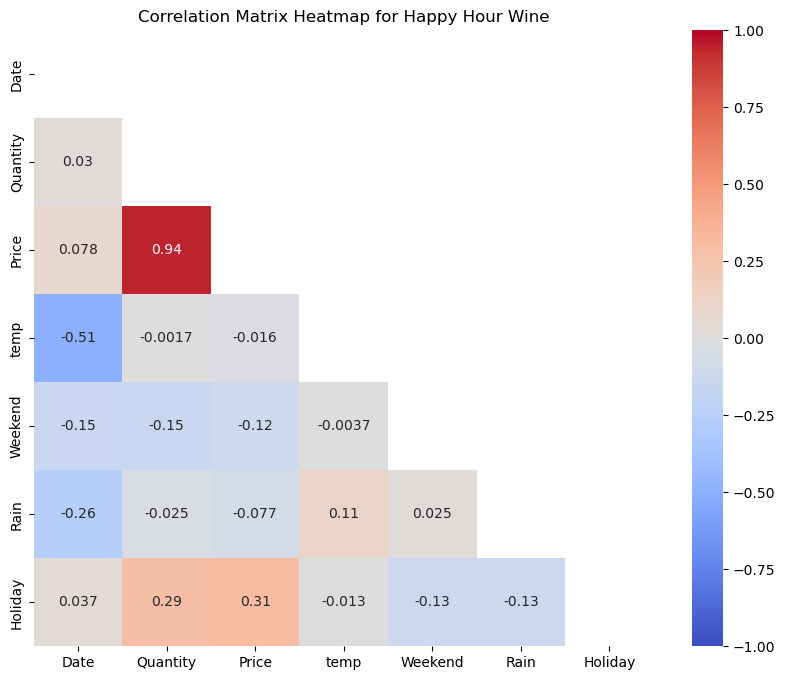

In [ ]:
categories2=[category for category in categories if len(df_hourly_dict[category])>100]

Corr_weekend={}
Corr_Rain={}
Corr_Holiday={}
Corr_temp={}

for category in categories2:

    coeff=df_hourly_dict[category]['Quantity'].corr(df_hourly_dict[category]['Weekend'])
    if coeff>0.20:
        Corr_weekend[category]=coeff
    coeff=df_hourly_dict[category]['Quantity'].corr(df_hourly_dict[category]['temp'])
    if coeff>0.2:
        Corr_temp[category]=coeff
    coeff=df_hourly_dict[category]['Quantity'].corr(df_hourly_dict[category]['Rain'])
    if coeff>0.2:
        Corr_Rain[category]=coeff
    coeff=df_hourly_dict[category]['Quantity'].corr(df_hourly_dict[category]['Holiday'])
    if coeff>0.2:
        Corr_Holiday[category]=coeff

print("Rain correalation")
print(Corr_Rain)
print("Temperature correalation")
print(Corr_temp)
print("Holiday correlation")
print(Corr_Holiday)
print("Weekend correlation")
print(Corr_weekend)


def assign_zero(matrix, threshold):
    # Create a copy of the matrix to avoid modifying the original
    result = matrix.copy()
    # Assign 0 to elements smaller than the threshold
    result[result < threshold] = 0
    return result


item='Happy Hour Wine'
corr_matrix = df_hourly_dict[item].drop(columns=['Week']).corr()
#corr_matrix = assign_zero(df_hourly_dict[item].corr(),0.2)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', vmin=-1, vmax=1)
plt.gcf().set_facecolor('none')
# Add title
plt.title(f'Correlation Matrix Heatmap for {item}')


# Total items Analysis

<Axes: title={'center': 'Quantity'}>

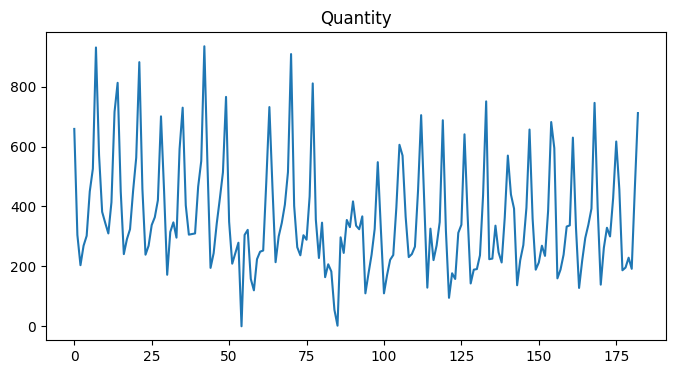

In [14]:
original_df = pd.read_csv('sales-output-new-7.csv')

original_df.columns = original_df.columns.str.strip()
original_df['Date'] = original_df['Date'].apply(lambda x: x if len(x) == 19 else f"{x}:00")
original_df['Date'] = pd.to_datetime(original_df['Date'])


In [18]:




daily_quantity = original_df.resample('D', on='Date')['Price'].sum().reset_index()

fig = px.line(daily_quantity, x='Date', y='Price', title='Daily Sales', markers=True)

fig.update_layout(
    title='Daily Aggregate of Quantity',
    xaxis_title=None,  # Hide the x-axis title as per the original
    yaxis_title='Revenue ($)',
    title_font_size=24,
    xaxis_title_font_size=18,
    yaxis_title_font_size=18,
    yaxis=dict(tickfont=dict(size=14),showgrid=False),
    xaxis=dict(tickfont=dict(size=14),showgrid=False),

    width=1000,
    height=600,
    margin=dict(l=50, r=50, t=100, b=50)
)

fig.update_traces(marker=dict(size=6, color='blue'))

fig.show()


Decomposing the data into trenbd and seasonal and residual components

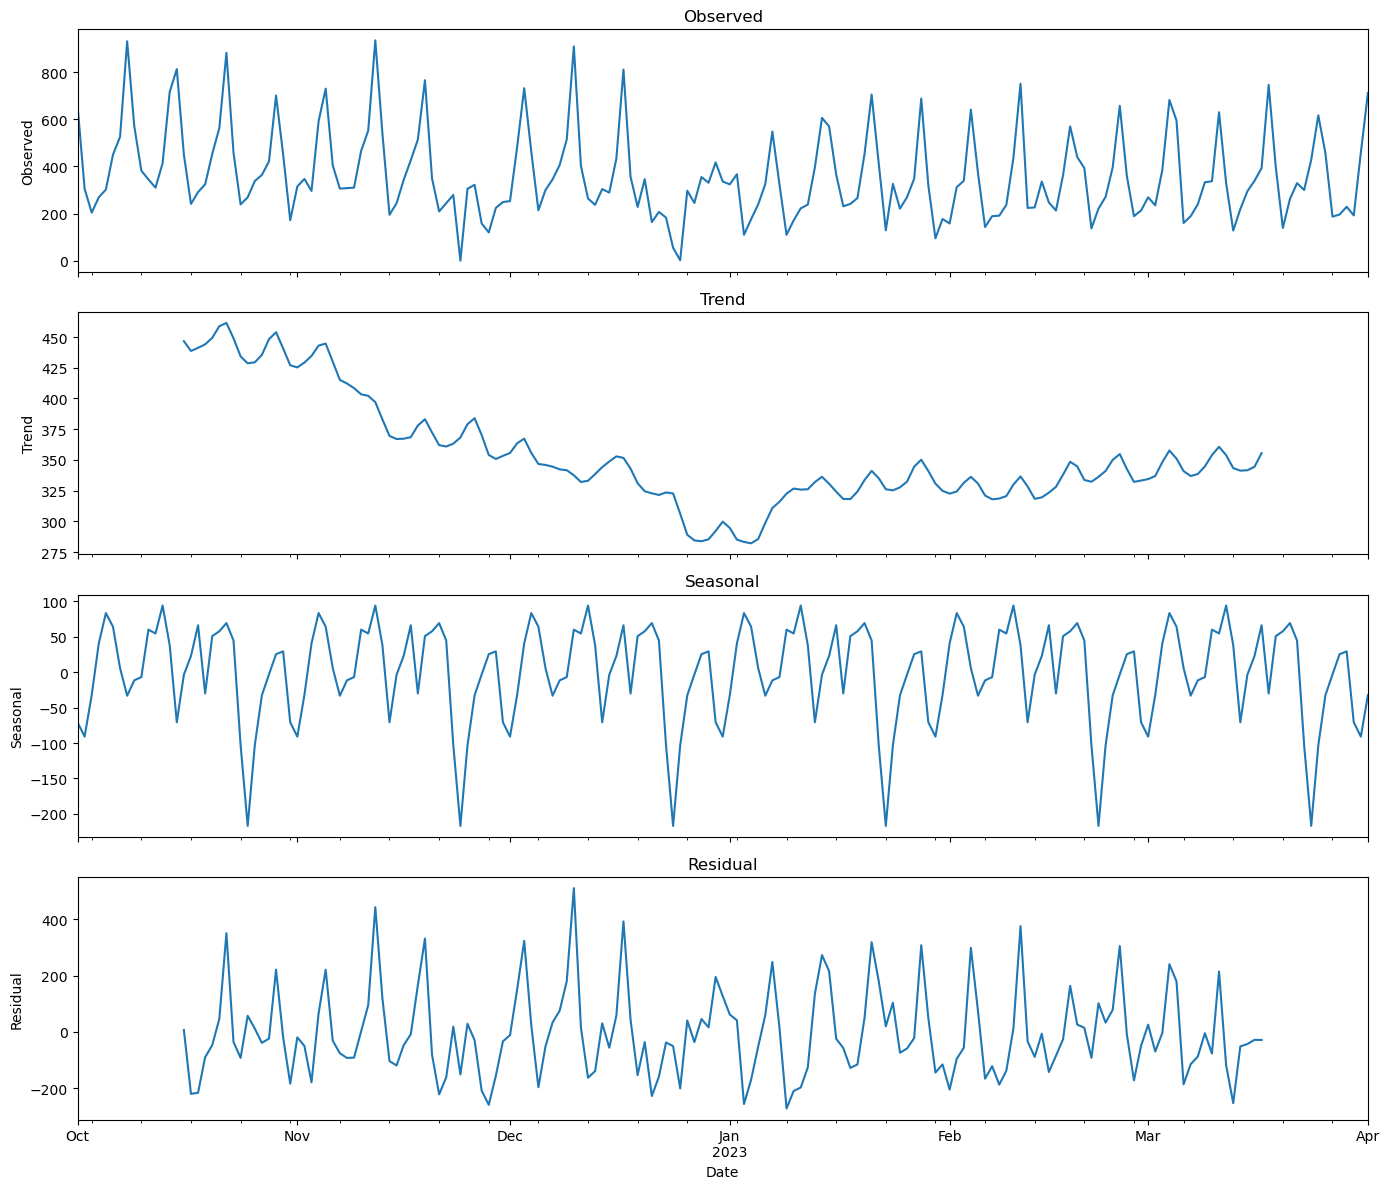

In [ ]:

daily_quantity.set_index('Date', inplace=True)

decomposition = seasonal_decompose(daily_quantity['Quantity'], model='additive', period=30)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

decomposition.observed.plot(ax=ax1, legend=False)
ax1.set_ylabel('Observed')
ax1.set_title('Observed')

decomposition.trend.plot(ax=ax2, legend=False)
ax2.set_ylabel('Trend')
ax2.set_title('Trend')

decomposition.seasonal.plot(ax=ax3, legend=False)
ax3.set_ylabel('Seasonal')
ax3.set_title('Seasonal')

decomposition.resid.plot(ax=ax4, legend=False)
ax4.set_ylabel('Residual')
ax4.set_title('Residual')

plt.tight_layout()
plt.show()

Sales by weekdays

In [22]:



original_df['Day'] = original_df['Date'].dt.day_name()

days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']


fig = go.Figure()

for day in days:
    day_sales = original_df[original_df['Day'] == day]
    day_sales_trends = day_sales.groupby(day_sales['Date'].dt.date).agg({'Price': 'sum'}).reset_index()
    fig.add_trace(go.Scatter(
        x=day_sales_trends['Date'],
        y=day_sales_trends['Price'],
        mode='lines+markers',
        name=day
    ))

fig.update_layout(
    title='Sales Trends by Weekday',
    xaxis_title='Date',
    yaxis_title='Revenue ($)',
    legend_title='Day of the Week',
    template='plotly_white',
    width=1000,
    height=600,

)

fig.show()


In [32]:
df_filtered = original_df[['Category_id', 'Item Name', 'Date', 'Quantity', 'Price']]

weekday_sales = df_filtered.groupby(df_filtered['Date'].dt.day_name()).agg({'Price': 'sum'}).reset_index()

weekday_sales['Day'] = pd.Categorical(weekday_sales['Date'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
weekday_sales = weekday_sales.sort_values('Day')

fig = go.Figure(data=[go.Bar(
    x=weekday_sales['Day'],
    y=weekday_sales['Price'],
    text=weekday_sales['Price'],
    textposition='auto',
    marker=dict(color=weekday_sales['Price'], colorscale='Viridis')
)])


fig.update_layout(
    title='Total Weekday shares',
    scene=dict(
        xaxis=dict(title='Day of the Week'),
        yaxis=dict(title='Revenue ($)'),
        zaxis=dict(title=''),
        bgcolor='rgba(0,0,0,0)'
    ),

    width=1000,
    height=600
)


fig.show()

**Most profitable items**

In [26]:
import pandas as pd
import plotly.graph_objects as go

df_filtered = original_df[original_df['Item Name'] != 'Non-Cash ADJ']


product_revenue = df_filtered.groupby('Item Name').agg({'Price': 'sum'}).reset_index()

total_revenue = product_revenue['Price'].sum()

top_5_revenue_products = product_revenue.sort_values(by='Price', ascending=False).head(5)

top_5_revenue_products['Percentage'] = (top_5_revenue_products['Price'] / total_revenue) * 100

fig = go.Figure(data=[go.Bar(
    x=top_5_revenue_products['Price'],
    y=top_5_revenue_products['Item Name'],
    text=[f'${value/1000:,.2f}k ({percentage:.2f}%)' for value, percentage in zip(top_5_revenue_products['Price'], top_5_revenue_products['Percentage'])],
    textposition='auto',
    orientation='h',
    marker=dict(color=top_5_revenue_products['Price'], colorscale='Viridis')
)])

fig.update_layout(
    title='Top 5 Revenue-Generating Products',
    title_font_size=24,
    xaxis_title='Revenue (K$)',
    xaxis_title_font_size=18,
    yaxis_title='Product',
    yaxis_title_font_size=18,
    yaxis=dict(tickfont=dict(size=14)),
    xaxis=dict(tickfont=dict(size=14)),

    width=1000,
    height=600,
    margin=dict(l=100, r=50, t=100, b=50)
)


fig.show()





**Total share in revenue by catagory**

In [31]:


df_filtered = original_df[['Category_id', 'Item Name', 'Date', 'Quantity', 'Price']]

category_names = {
    "30d04694-ff34-4166-9d97-1a92950c3e73": "Pasta Dishes",
    "d3e202ef-e7f4-4cc9-a439-14b8baf9c6e0": "Breakfast & Brunch",
    "8b1e2431-d1bd-4d68-be97-fd018d94fcf0": "Cocktails",
    "089655cd-eba5-435a-8472-b4a0e2508561": "Adjustments",
    "8c3a899d-bf85-48bc-bc81-34f212e43dd4": "Coffee & Tea",
    "e77037c3-a6fc-4ecd-9f76-dea556ebed26": "Appetizers",
    "03a97141-1501-4b06-828c-7bed5b44f2bb": "Sides",
    "2f320d8e-6140-47e1-aea3-334033b8e752": "Sandwiches & Burgers",
    "20495b36-01e7-40cf-8e6a-417889f8cbe8": "Cocktails",
    "38c34f47-baa8-4cb0-9bbc-9c281a549e0b": "Non-Alcoholic Beverages",
    "c76a0a7c-ba8d-472a-9649-7f64efb6061c": "Main Courses",
    "72dc6c2b-de5c-45c9-a8d3-e96e357fd0b1": "Wines",
    "0154e275-d791-42dd-ae84-8350dae383d9": "Salads",
    "ba3d6b42-05af-4dc6-b46c-cb6f63a3bf5f": "Beers",
    "921510bc-48c0-48af-9a8b-8bd3684ce5a7": "Desserts",
    "74a9b2a9-3b1f-4c63-a364-fbe30ea7bfb9": "Miscellaneous Food"
}

df_filtered['Category Name'] = df_filtered['Category_id'].map(category_names)

total_sales_by_category = df_filtered.groupby('Category Name').agg({'Price': 'sum'}).reset_index()

total_sales_by_category = total_sales_by_category.sort_values(by='Price', ascending=True)

total_sales_by_category['Pull'] = [0.2 if i >= len(total_sales_by_category) - 3 else 0 for i in range(len(total_sales_by_category))]

fig = go.Figure(data=[go.Pie(
    labels=total_sales_by_category['Category Name'],
    values=total_sales_by_category['Price'],
    pull=total_sales_by_category['Pull'],
    textinfo='label+percent',
    insidetextorientation='radial'
)])

fig.update_layout(
    title='Total Sales by Category',
    showlegend=True
)

fig.show()


<ipython-input-31-612eba77c5d2>:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Modelling total daily sales

In [35]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

hourly_sales = original_df.resample('H', on='Date').sum()

adf_result = adfuller(hourly_sales['Price'])

adf_summary = {
    'ADF Statistic': adf_result[0],
    'p-value': adf_result[1],
    'Critical Values': adf_result[4]
}

adf_summary


{'ADF Statistic': -7.318256578216894,
 'p-value': 1.213134284985376e-10,
 'Critical Values': {'1%': -3.4318527927183196,
  '5%': -2.86220405019551,
  '10%': -2.5671234784459993}}

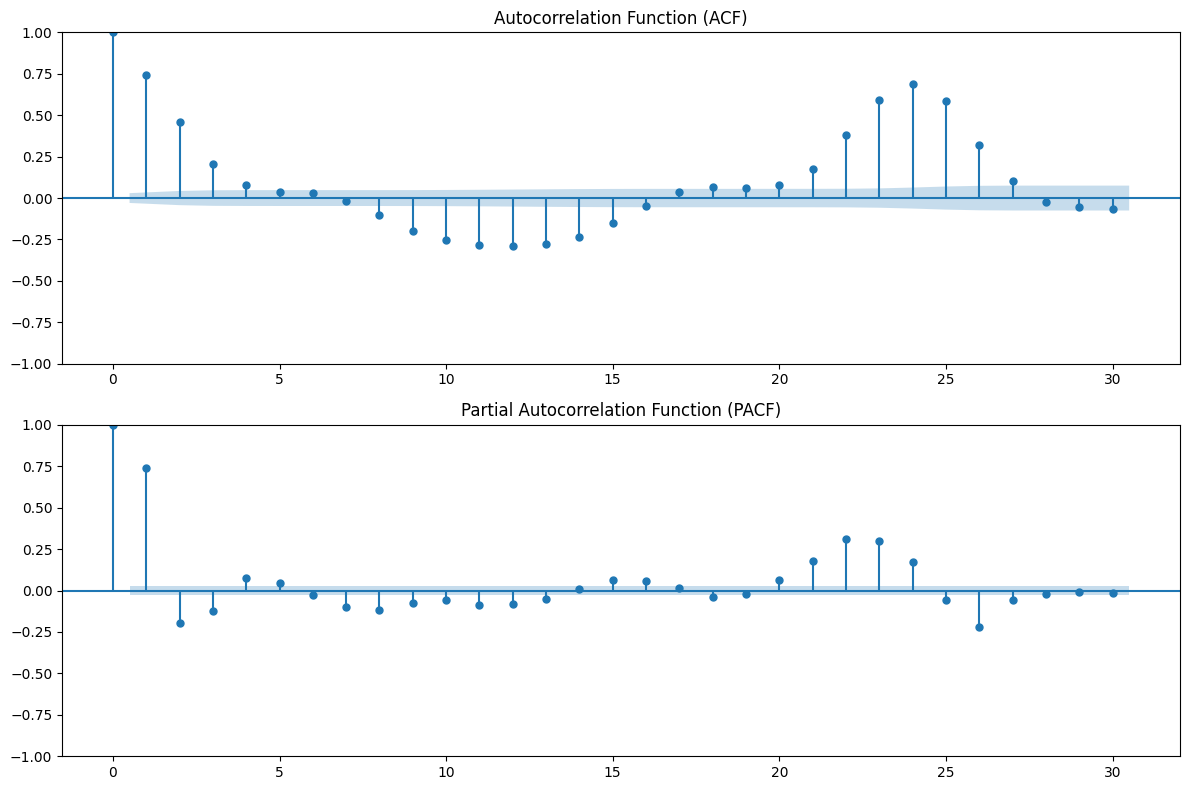

In [36]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(hourly_sales['Price'], lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

plot_pacf(hourly_sales['Price'], lags=30, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

Checking for the best parameters for ARIMA and plottin the results

ARIMA(0, 0, 0) RMSE=2110.1582770849877
ARIMA(0, 0, 1) RMSE=2112.5858937869993
ARIMA(0, 0, 2) RMSE=2113.056732057771
ARIMA(0, 0, 3) RMSE=2106.74887947182
ARIMA(0, 0, 4) RMSE=2104.0180588683634
ARIMA(0, 0, 5) RMSE=2070.9214793358606
ARIMA(0, 1, 0) RMSE=2146.9720013783835
ARIMA(0, 1, 1) RMSE=2141.654794771829
ARIMA(0, 1, 2) RMSE=2127.016452157332
ARIMA(0, 1, 3) RMSE=2111.4971554538615
ARIMA(0, 1, 4) RMSE=2132.1425039116043
ARIMA(0, 1, 5) RMSE=2129.2994974269723
ARIMA(1, 0, 0) RMSE=2115.624112511808
ARIMA(1, 0, 1) RMSE=2113.1423039462843
ARIMA(1, 0, 2) RMSE=2109.472949039188
ARIMA(1, 0, 3) RMSE=2104.573669702539
ARIMA(1, 0, 4) RMSE=2099.3491928021313
ARIMA(1, 0, 5) RMSE=2084.4249558916645
ARIMA(1, 1, 0) RMSE=2164.649699905291
ARIMA(1, 1, 1) RMSE=2114.1100834020285
ARIMA(1, 1, 2) RMSE=2123.21541044796


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(1, 1, 3) RMSE=2124.05723010466


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 1, 4) RMSE=2130.077085216779


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(1, 1, 5) RMSE=2126.578150707516
ARIMA(2, 0, 0) RMSE=2096.019801588514
ARIMA(2, 0, 1) RMSE=2081.244430768163
ARIMA(2, 0, 2) RMSE=2083.344828158289


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 0, 3) RMSE=2105.0158120122182
ARIMA(2, 0, 4) RMSE=2044.321713018229
ARIMA(2, 0, 5) RMSE=2049.559374205027
ARIMA(2, 1, 0) RMSE=2335.5635078451955
ARIMA(2, 1, 1) RMSE=2120.36695494793


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(2, 1, 2) RMSE=2109.3447837208278


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 3) RMSE=1293.2854297666124


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 4) RMSE=2118.393155874076


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(2, 1, 5) RMSE=2063.958526298297
ARIMA(3, 0, 0) RMSE=2086.6100956205437
ARIMA(3, 0, 1) RMSE=2081.4561812824372


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(3, 0, 2) RMSE=1297.001908285107


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(3, 0, 3) RMSE=1292.7456914984914


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(3, 0, 4) RMSE=1285.9865860971515


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(3, 0, 5) RMSE=2037.285058104002
ARIMA(3, 1, 0) RMSE=2302.089280776121
ARIMA(3, 1, 1) RMSE=2111.9883131179718


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(3, 1, 2) RMSE=2097.2579606353893


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(3, 1, 3) RMSE=2100.0422948514065
ARIMA(3, 1, 4) RMSE=2109.030505303618


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(3, 1, 5) RMSE=2112.4005824495275
ARIMA(4, 0, 0) RMSE=2079.019766424924
ARIMA(4, 0, 1) RMSE=2080.238478932148


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(4, 0, 2) RMSE=1921.4783088977974


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 0, 3) RMSE=1302.2872527076747


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 0, 4) RMSE=1236.1295832744913


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(4, 0, 5) RMSE=1007.2713238155917
ARIMA(4, 1, 0) RMSE=2220.5581950613487
ARIMA(4, 1, 1) RMSE=2095.4893380770177


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 1, 2) RMSE=2101.9066408866083


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 1, 3) RMSE=2115.040609627593


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(4, 1, 4) RMSE=1597.3553026742663


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(4, 1, 5) RMSE=1372.600559172715
ARIMA(5, 0, 0) RMSE=2085.9245344442315
ARIMA(5, 0, 1) RMSE=2093.4503984901426


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(5, 0, 2) RMSE=1762.4148448035533
ARIMA(5, 0, 3) RMSE=2015.155135695496


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 0, 4) RMSE=982.6541143025296


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 0, 5) RMSE=1192.410576629515
ARIMA(5, 1, 0) RMSE=1942.8545423475402
ARIMA(5, 1, 1) RMSE=1920.7573272597106


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



ARIMA(5, 1, 2) RMSE=1710.790849170976


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 1, 3) RMSE=1679.386173620456


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 1, 4) RMSE=1059.1977457576156


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(5, 1, 5) RMSE=1219.8110099531025
Best ARIMA(5, 0, 4) RMSE=982.6541143025296


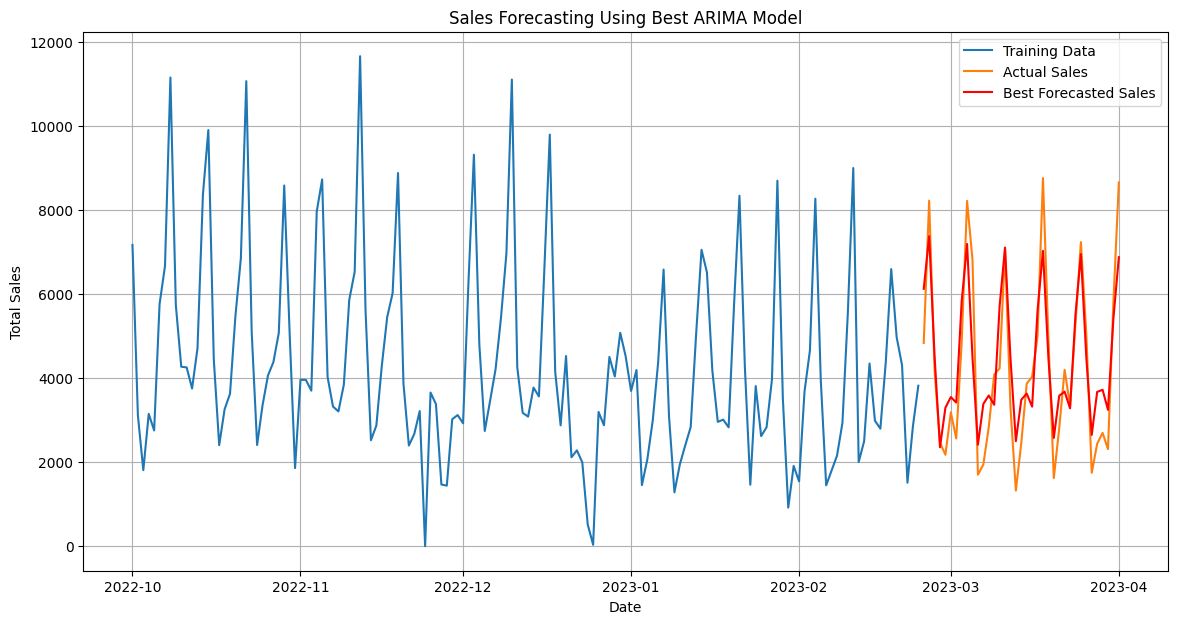

Best Root Mean Squared Error (RMSE): 982.6541143025296


In [37]:




daily_sales = original_df.resample('D', on='Date').sum().reset_index()
daily_sales['Total_Sales'] = daily_sales['Price']

train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales[:train_size], daily_sales[train_size:]

def evaluate_arima_model(order):
    model = ARIMA(train['Total_Sales'], order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))
    mse = mean_squared_error(test['Total_Sales'], forecast)
    rmse = np.sqrt(mse)
    return rmse, forecast

p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)

best_score, best_order, best_forecast = float('inf'), None, None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                rmse, forecast = evaluate_arima_model(order)
                if rmse < best_score:
                    best_score, best_order, best_forecast = rmse, order, forecast
                print(f"ARIMA{order} RMSE={rmse}")
            except:
                continue

print(f'Best ARIMA{best_order} RMSE={best_score}')

plt.figure(figsize=(14, 7))
plt.plot(train['Date'], train['Total_Sales'], label='Training Data')
plt.plot(test['Date'], test['Total_Sales'], label='Actual Sales')
plt.plot(test['Date'], best_forecast, label='Best Forecasted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Sales Forecasting Using Best ARIMA Model')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best Root Mean Squared Error (RMSE): {best_score}")


Forcasting

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



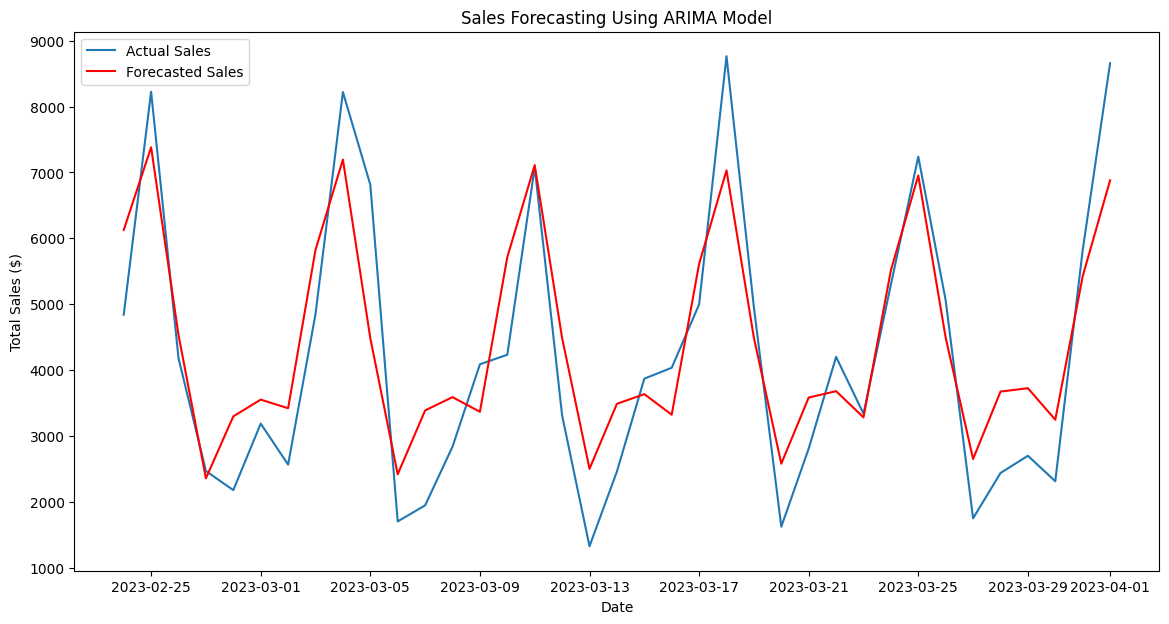

Root Mean Squared Error (RMSE): 982.6541143025296


In [38]:
daily_sales = original_df.resample('D', on='Date').sum().reset_index()
daily_sales['Total_Sales'] = daily_sales['Price']

train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales[:train_size], daily_sales[train_size:]

model = ARIMA(train['Total_Sales'], order=(5, 0, 4))
model_fit = model.fit()


forecast = model_fit.forecast(steps=len(test))


mse = mean_squared_error(test['Total_Sales'], forecast)
rmse = np.sqrt(mse)

plt.figure(figsize=(14, 7))
plt.plot(daily_sales['Date'][train_size:], test['Total_Sales'], label='Actual Sales')
plt.plot(daily_sales['Date'][train_size:], forecast, label='Forecasted Sales', color='red')
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.title('Sales Forecasting Using ARIMA Model')
plt.legend()
plt.gca().set_facecolor('None')
plt.show()

print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



          Date  Actual Sales  Predicted Sales  Relative Error
173 2023-03-23       3337.09      3281.743514        0.016585
174 2023-03-24       5298.29      5514.155752        0.040743
175 2023-03-25       7238.82      6953.742193        0.039382
176 2023-03-26       5056.25      4489.616798        0.112066
177 2023-03-27       1749.09      2649.924530        0.515030
178 2023-03-28       2436.75      3672.590462        0.507168
179 2023-03-29       2698.44      3724.140624        0.380109
180 2023-03-30       2311.61      3245.798827        0.404129
181 2023-03-31       5819.69      5423.186928        0.068131
182 2023-04-01       8658.18      6879.720328        0.205408


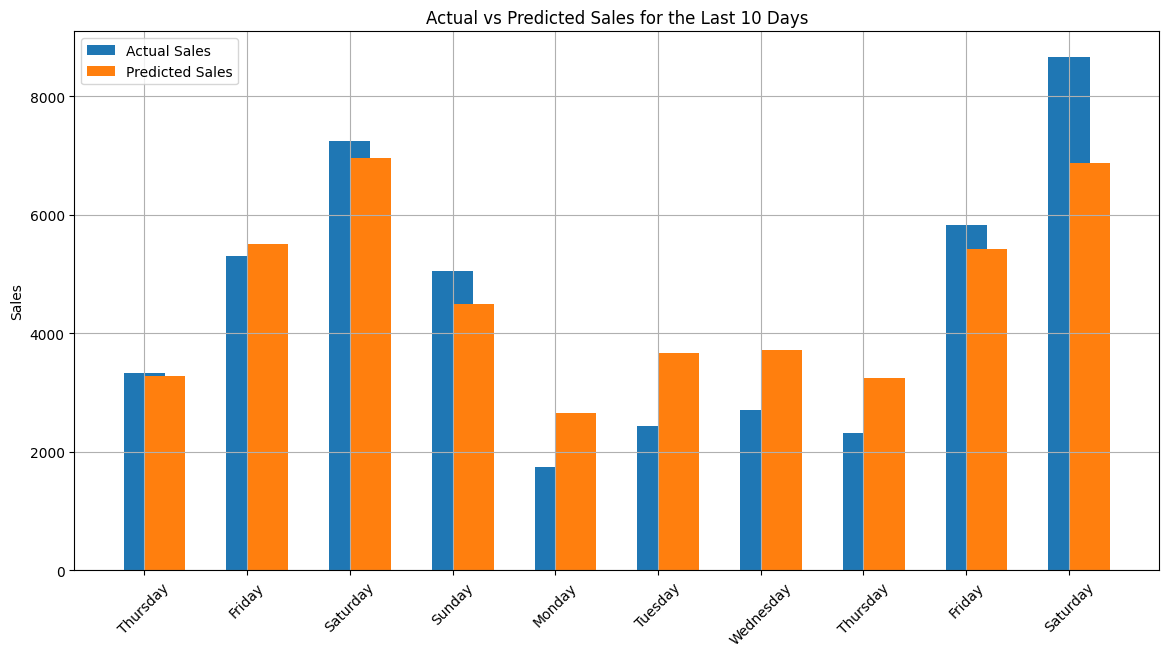

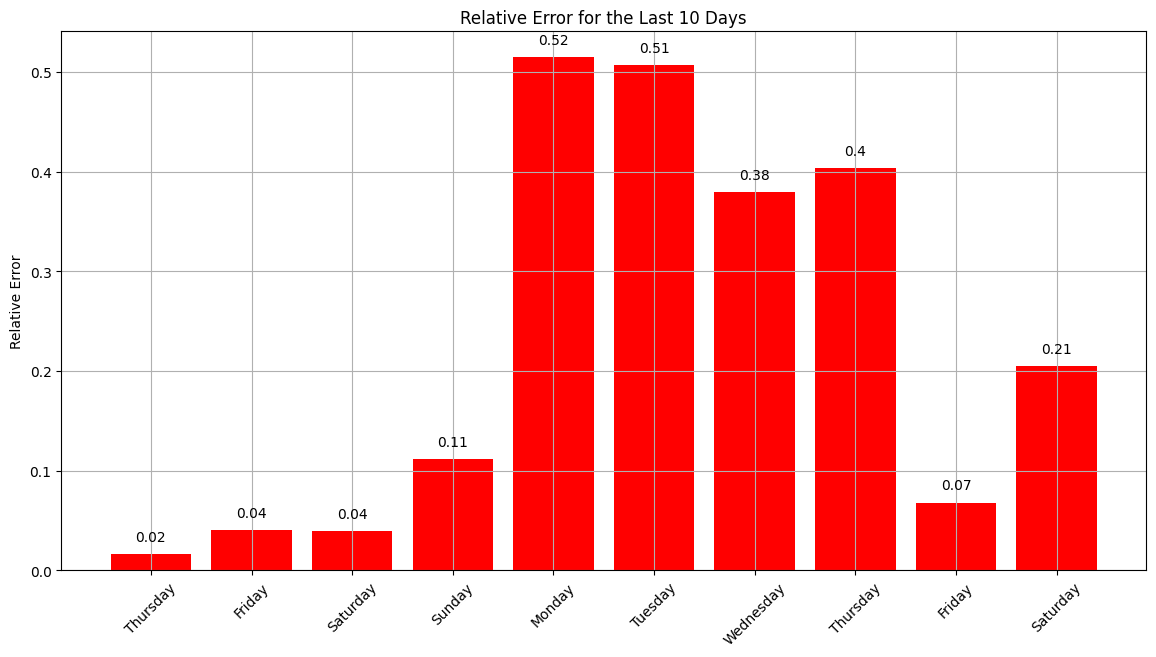

In [40]:
import matplotlib.dates as mdates

model = ARIMA(train['Total_Sales'], order=(5, 0, 4))
model_fit = model.fit()


forecast = model_fit.forecast(steps=len(test))

actual_10_days = test['Total_Sales'][-10:].values
predicted_10_days = forecast[-10:]

relative_errors = np.abs((actual_10_days - predicted_10_days) / actual_10_days)

prediction_df = pd.DataFrame({
    'Date': test['Date'][-10:],
    'Actual Sales': actual_10_days,
    'Predicted Sales': predicted_10_days,
    'Relative Error': relative_errors
})

print(prediction_df)

plt.figure(figsize=(14, 7))
plt.bar(prediction_df['Date'], prediction_df['Actual Sales'], width=0.4, align='center', label='Actual Sales')
plt.bar(prediction_df['Date'], prediction_df['Predicted Sales'], width=0.4, align='edge', label='Predicted Sales')
plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales for the Last 10 Days')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%A'))
plt.show()

plt.figure(figsize=(14, 7))
bars = plt.bar(prediction_df['Date'], prediction_df['Relative Error'], color='red')

for bar, error in zip(bars, prediction_df['Relative Error']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(error, 2), ha='center', va='bottom')

plt.ylabel('Relative Error')
plt.title('Relative Error for the Last 10 Days')
plt.grid(True)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%A'))
plt.show()



Since the data shows seasonality, we use SARIMA model, optimize for the best parameters and compare the results with the previous model

SARIMA(0, 0, 0)x(0, 0, 0, 7) - RMSE: 4722.382659190053
SARIMA(0, 0, 0)x(0, 0, 1, 7) - RMSE: 4527.617544359454
SARIMA(0, 0, 0)x(0, 0, 2, 7) - RMSE: 4359.52428729459
SARIMA(0, 0, 0)x(0, 1, 0, 7) - RMSE: 1370.4493918064622
SARIMA(0, 0, 0)x(0, 1, 1, 7) - RMSE: 864.5593267846359
SARIMA(0, 0, 0)x(0, 1, 2, 7) - RMSE: 871.8137496969251
SARIMA(0, 0, 0)x(0, 2, 0, 7) - RMSE: 7938.948463287344
SARIMA(0, 0, 0)x(0, 2, 1, 7) - RMSE: 1448.5670184148973


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 0, 0)x(0, 2, 2, 7) - RMSE: 1046.8831312603672
SARIMA(0, 0, 0)x(1, 0, 0, 7) - RMSE: 1917.5905593878558
SARIMA(0, 0, 0)x(1, 0, 1, 7) - RMSE: 890.7547325984393
SARIMA(0, 0, 0)x(1, 0, 2, 7) - RMSE: 874.4568021286569
SARIMA(0, 0, 0)x(1, 1, 0, 7) - RMSE: 1163.397886005712
SARIMA(0, 0, 0)x(1, 1, 1, 7) - RMSE: 860.9635772593027
SARIMA(0, 0, 0)x(1, 1, 2, 7) - RMSE: 875.1868660810712
SARIMA(0, 0, 0)x(1, 2, 0, 7) - RMSE: 4621.5400158290995
SARIMA(0, 0, 0)x(1, 2, 1, 7) - RMSE: 1288.977951472347


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 0, 0)x(1, 2, 2, 7) - RMSE: 1448.6405343904507
SARIMA(0, 0, 0)x(2, 0, 0, 7) - RMSE: 1381.5479948849184
SARIMA(0, 0, 0)x(2, 0, 1, 7) - RMSE: 877.4799857633894


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 0, 0)x(2, 0, 2, 7) - RMSE: 882.0812577436657
SARIMA(0, 0, 0)x(2, 1, 0, 7) - RMSE: 1038.8631280888194
SARIMA(0, 0, 0)x(2, 1, 1, 7) - RMSE: 876.7487971029645


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 0, 0)x(2, 1, 2, 7) - RMSE: 879.633181925257
SARIMA(0, 0, 0)x(2, 2, 0, 7) - RMSE: 3414.258968428662
SARIMA(0, 0, 0)x(2, 2, 1, 7) - RMSE: 1105.1686801418628


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 0, 0)x(2, 2, 2, 7) - RMSE: 951.3794047129952
SARIMA(0, 0, 1)x(0, 0, 0, 7) - RMSE: 4699.738660840142
SARIMA(0, 0, 1)x(0, 0, 1, 7) - RMSE: 4502.6188779996
SARIMA(0, 0, 1)x(0, 0, 2, 7) - RMSE: 4317.001892587984
SARIMA(0, 0, 1)x(0, 1, 0, 7) - RMSE: 1356.3321982176637
SARIMA(0, 0, 1)x(0, 1, 1, 7) - RMSE: 859.7651677095162


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 0, 1)x(0, 1, 2, 7) - RMSE: 866.5322341233748
SARIMA(0, 0, 1)x(0, 2, 0, 7) - RMSE: 7821.57413538746


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 0, 1)x(0, 2, 1, 7) - RMSE: 1465.8210593590677


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 0, 1)x(0, 2, 2, 7) - RMSE: 981.983176076202
SARIMA(0, 0, 1)x(1, 0, 0, 7) - RMSE: 2222.247740650369
SARIMA(0, 0, 1)x(1, 0, 1, 7) - RMSE: 875.9474561011253


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 0, 1)x(1, 0, 2, 7) - RMSE: 859.9834984887901
SARIMA(0, 0, 1)x(1, 1, 0, 7) - RMSE: 1129.2755294197498
SARIMA(0, 0, 1)x(1, 1, 1, 7) - RMSE: 857.9729069209802


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 0, 1)x(1, 1, 2, 7) - RMSE: 879.5416027215501
SARIMA(0, 0, 1)x(1, 2, 0, 7) - RMSE: 4485.369400089554


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 0, 1)x(1, 2, 1, 7) - RMSE: 1277.42712811421


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 0, 1)x(1, 2, 2, 7) - RMSE: 1479.047082525279
SARIMA(0, 0, 1)x(2, 0, 0, 7) - RMSE: 1562.7979821204985


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 0, 1)x(2, 0, 1, 7) - RMSE: 894.1884185069658
SARIMA(0, 0, 1)x(2, 0, 2, 7) - RMSE: 861.6700016799151
SARIMA(0, 0, 1)x(2, 1, 0, 7) - RMSE: 1028.9022823058772
SARIMA(0, 0, 1)x(2, 1, 1, 7) - RMSE: 872.2709254641775


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 0, 1)x(2, 1, 2, 7) - RMSE: 849.4567796108869
SARIMA(0, 0, 1)x(2, 2, 0, 7) - RMSE: 3206.2578798695235


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 0, 1)x(2, 2, 1, 7) - RMSE: 1087.618931196693
SARIMA(0, 0, 1)x(2, 2, 2, 7) - RMSE: 940.5279402928837
SARIMA(0, 0, 2)x(0, 0, 0, 7) - RMSE: 4624.148192772982
SARIMA(0, 0, 2)x(0, 0, 1, 7) - RMSE: 4461.55232364806
SARIMA(0, 0, 2)x(0, 0, 2, 7) - RMSE: 4284.076519321458
SARIMA(0, 0, 2)x(0, 1, 0, 7) - RMSE: 1318.026890333859
SARIMA(0, 0, 2)x(0, 1, 1, 7) - RMSE: 864.3619903524009


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 0, 2)x(0, 1, 2, 7) - RMSE: 865.119620367501
SARIMA(0, 0, 2)x(0, 2, 0, 7) - RMSE: 7428.323878359959
SARIMA(0, 0, 2)x(0, 2, 1, 7) - RMSE: 1504.4317573921167


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 0, 2)x(0, 2, 2, 7) - RMSE: 1010.2893550742745
SARIMA(0, 0, 2)x(1, 0, 0, 7) - RMSE: 2306.84606094967
SARIMA(0, 0, 2)x(1, 0, 1, 7) - RMSE: 871.8516005017366


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 0, 2)x(1, 0, 2, 7) - RMSE: 865.5253755208716
SARIMA(0, 0, 2)x(1, 1, 0, 7) - RMSE: 1103.122508238968
SARIMA(0, 0, 2)x(1, 1, 1, 7) - RMSE: 860.278196316363


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 0, 2)x(1, 1, 2, 7) - RMSE: 882.409498894054
SARIMA(0, 0, 2)x(1, 2, 0, 7) - RMSE: 4202.957959209056


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 0, 2)x(1, 2, 1, 7) - RMSE: 1337.0609318882373


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 0, 2)x(1, 2, 2, 7) - RMSE: 1067.7297355286296
SARIMA(0, 0, 2)x(2, 0, 0, 7) - RMSE: 1611.3161091288741


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 0, 2)x(2, 0, 2, 7) - RMSE: 888.5815585221807
SARIMA(0, 0, 2)x(2, 1, 0, 7) - RMSE: 1015.5197761593015


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 0, 2)x(2, 1, 1, 7) - RMSE: 870.2938759095163


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 0, 2)x(2, 1, 2, 7) - RMSE: 889.4489450486345
SARIMA(0, 0, 2)x(2, 2, 0, 7) - RMSE: 3127.563857470276


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 0, 2)x(2, 2, 1, 7) - RMSE: 1127.8457740930571
SARIMA(0, 0, 2)x(2, 2, 2, 7) - RMSE: 934.1741353161757
SARIMA(0, 1, 0)x(0, 0, 0, 7) - RMSE: 2146.9720013783835
SARIMA(0, 1, 0)x(0, 0, 1, 7) - RMSE: 2085.2996916591273
SARIMA(0, 1, 0)x(0, 0, 2, 7) - RMSE: 2066.7783592215
SARIMA(0, 1, 0)x(0, 1, 0, 7) - RMSE: 3710.353986265273
SARIMA(0, 1, 0)x(0, 1, 1, 7) - RMSE: 1249.720329913486


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 1, 0)x(0, 1, 2, 7) - RMSE: 1364.3899912553186
SARIMA(0, 1, 0)x(0, 2, 0, 7) - RMSE: 12264.32520780715
SARIMA(0, 1, 0)x(0, 2, 1, 7) - RMSE: 3874.570795103386


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 1, 0)x(0, 2, 2, 7) - RMSE: 975.3260420947447
SARIMA(0, 1, 0)x(1, 0, 0, 7) - RMSE: 2070.9902518623794
SARIMA(0, 1, 0)x(1, 0, 1, 7) - RMSE: 1236.6746564114437


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 0)x(1, 0, 2, 7) - RMSE: 1421.4807872201463
SARIMA(0, 1, 0)x(1, 1, 0, 7) - RMSE: 2828.3735271661594
SARIMA(0, 1, 0)x(1, 1, 1, 7) - RMSE: 1339.3932452735492
SARIMA(0, 1, 0)x(1, 1, 2, 7) - RMSE: 1311.9571393193169
SARIMA(0, 1, 0)x(1, 2, 0, 7) - RMSE: 11176.437908492571
SARIMA(0, 1, 0)x(1, 2, 1, 7) - RMSE: 2865.496688032466


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 1, 0)x(1, 2, 2, 7) - RMSE: 3883.5923421757057
SARIMA(0, 1, 0)x(2, 0, 0, 7) - RMSE: 1942.2696383047075


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 0)x(2, 0, 1, 7) - RMSE: 1385.0672892667092
SARIMA(0, 1, 0)x(2, 0, 2, 7) - RMSE: 1419.2695178786341
SARIMA(0, 1, 0)x(2, 1, 0, 7) - RMSE: 1547.046640990546
SARIMA(0, 1, 0)x(2, 1, 1, 7) - RMSE: 1209.4239254031659


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 0)x(2, 1, 2, 7) - RMSE: 1219.3024744977283
SARIMA(0, 1, 0)x(2, 2, 0, 7) - RMSE: 4975.052133678577
SARIMA(0, 1, 0)x(2, 2, 1, 7) - RMSE: 1252.3514567961845


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 0)x(2, 2, 2, 7) - RMSE: 1171.795392897368
SARIMA(0, 1, 1)x(0, 0, 0, 7) - RMSE: 2141.654794771829
SARIMA(0, 1, 1)x(0, 0, 1, 7) - RMSE: 2100.0227259561566
SARIMA(0, 1, 1)x(0, 0, 2, 7) - RMSE: 2134.1000888316844
SARIMA(0, 1, 1)x(0, 1, 0, 7) - RMSE: 1775.6611599240227
SARIMA(0, 1, 1)x(0, 1, 1, 7) - RMSE: 1005.4129743694306


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 1, 1)x(0, 1, 2, 7) - RMSE: 1061.7968916997215
SARIMA(0, 1, 1)x(0, 2, 0, 7) - RMSE: 7984.148325526307
SARIMA(0, 1, 1)x(0, 2, 1, 7) - RMSE: 1518.5870489638958


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 1)x(0, 2, 2, 7) - RMSE: 1120.548786046818
SARIMA(0, 1, 1)x(1, 0, 0, 7) - RMSE: 1753.801048493765
SARIMA(0, 1, 1)x(1, 0, 1, 7) - RMSE: 942.7305832273864
SARIMA(0, 1, 1)x(1, 0, 2, 7) - RMSE: 1008.4588263725865
SARIMA(0, 1, 1)x(1, 1, 0, 7) - RMSE: 1721.8169294008776
SARIMA(0, 1, 1)x(1, 1, 1, 7) - RMSE: 1055.6038909049707
SARIMA(0, 1, 1)x(1, 1, 2, 7) - RMSE: 1060.9838044857374
SARIMA(0, 1, 1)x(1, 2, 0, 7) - RMSE: 4486.655758124638
SARIMA(0, 1, 1)x(1, 2, 1, 7) - RMSE: 1320.334737150984


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 1)x(1, 2, 2, 7) - RMSE: 1482.1009814874883
SARIMA(0, 1, 1)x(2, 0, 0, 7) - RMSE: 1544.8981938107675
SARIMA(0, 1, 1)x(2, 0, 1, 7) - RMSE: 999.1736570474255
SARIMA(0, 1, 1)x(2, 0, 2, 7) - RMSE: 932.419491236276
SARIMA(0, 1, 1)x(2, 1, 0, 7) - RMSE: 1362.443771102784
SARIMA(0, 1, 1)x(2, 1, 1, 7) - RMSE: 965.6478986918321


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 1)x(2, 1, 2, 7) - RMSE: 1018.3562510218568
SARIMA(0, 1, 1)x(2, 2, 0, 7) - RMSE: 4318.9537690723855
SARIMA(0, 1, 1)x(2, 2, 1, 7) - RMSE: 1052.2452163425567


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 1)x(2, 2, 2, 7) - RMSE: 1165.743299290297
SARIMA(0, 1, 2)x(0, 0, 0, 7) - RMSE: 2127.016452157332
SARIMA(0, 1, 2)x(0, 0, 1, 7) - RMSE: 2077.3290373147756


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 2)x(0, 0, 2, 7) - RMSE: 2027.8424953434858
SARIMA(0, 1, 2)x(0, 1, 0, 7) - RMSE: 1481.8348567328792
SARIMA(0, 1, 2)x(0, 1, 1, 7) - RMSE: 889.3418460622912


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 1, 2)x(0, 1, 2, 7) - RMSE: 913.1454965846203
SARIMA(0, 1, 2)x(0, 2, 0, 7) - RMSE: 8082.671949863937


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 1, 2)x(0, 2, 1, 7) - RMSE: 1402.1638721336126


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 1, 2)x(0, 2, 2, 7) - RMSE: 1050.7366024562455
SARIMA(0, 1, 2)x(1, 0, 0, 7) - RMSE: 1842.1519299167378


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 2)x(1, 0, 1, 7) - RMSE: 1027.166556429401
SARIMA(0, 1, 2)x(1, 0, 2, 7) - RMSE: 991.0787486007389
SARIMA(0, 1, 2)x(1, 1, 0, 7) - RMSE: 1470.69818779847
SARIMA(0, 1, 2)x(1, 1, 1, 7) - RMSE: 907.9855483065592


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 2)x(1, 1, 2, 7) - RMSE: 914.6510808883646
SARIMA(0, 1, 2)x(1, 2, 0, 7) - RMSE: 4403.839821910635


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 1, 2)x(1, 2, 1, 7) - RMSE: 1139.1155156798322


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 2)x(1, 2, 2, 7) - RMSE: 1231.3050548484225
SARIMA(0, 1, 2)x(2, 0, 0, 7) - RMSE: 1665.1181209076706


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 2)x(2, 0, 1, 7) - RMSE: 991.7699686855459


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 2)x(2, 0, 2, 7) - RMSE: 1006.6237968526436
SARIMA(0, 1, 2)x(2, 1, 0, 7) - RMSE: 1211.4376707877807
SARIMA(0, 1, 2)x(2, 1, 1, 7) - RMSE: 871.5988678036924


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 2)x(2, 1, 2, 7) - RMSE: 889.3100760428781
SARIMA(0, 1, 2)x(2, 2, 0, 7) - RMSE: 3181.29789072647


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 2)x(2, 2, 1, 7) - RMSE: 1021.9719674016559


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 1, 2)x(2, 2, 2, 7) - RMSE: 1297.0144569701213
SARIMA(0, 2, 0)x(0, 0, 0, 7) - RMSE: 20879.00576879492
SARIMA(0, 2, 0)x(0, 0, 1, 7) - RMSE: 26487.99282013135
SARIMA(0, 2, 0)x(0, 0, 2, 7) - RMSE: 30290.683081199626
SARIMA(0, 2, 0)x(0, 1, 0, 7) - RMSE: 68551.2750847572
SARIMA(0, 2, 0)x(0, 1, 1, 7) - RMSE: 14319.64124533072


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 2, 0)x(0, 1, 2, 7) - RMSE: 17210.831269680093
SARIMA(0, 2, 0)x(0, 2, 0, 7) - RMSE: 268789.29327683477
SARIMA(0, 2, 0)x(0, 2, 1, 7) - RMSE: 73876.55024227468


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 2, 0)x(0, 2, 2, 7) - RMSE: 16927.994390027794
SARIMA(0, 2, 0)x(1, 0, 0, 7) - RMSE: 40639.35731362052
SARIMA(0, 2, 0)x(1, 0, 1, 7) - RMSE: 14346.973357888925


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 2, 0)x(1, 0, 2, 7) - RMSE: 17781.698416950512
SARIMA(0, 2, 0)x(1, 1, 0, 7) - RMSE: 37609.407795562714
SARIMA(0, 2, 0)x(1, 1, 1, 7) - RMSE: 16205.419806887481


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 2, 0)x(1, 1, 2, 7) - RMSE: 12585.37056442173
SARIMA(0, 2, 0)x(1, 2, 0, 7) - RMSE: 228479.75398431806
SARIMA(0, 2, 0)x(1, 2, 1, 7) - RMSE: 42465.34316434467


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 2, 0)x(1, 2, 2, 7) - RMSE: 72998.20964114308
SARIMA(0, 2, 0)x(2, 0, 0, 7) - RMSE: 32908.33006154322
SARIMA(0, 2, 0)x(2, 0, 1, 7) - RMSE: 16784.125233523377
SARIMA(0, 2, 0)x(2, 0, 2, 7) - RMSE: 13432.361166607077
SARIMA(0, 2, 0)x(2, 1, 0, 7) - RMSE: 1094.4862871087234
SARIMA(0, 2, 0)x(2, 1, 1, 7) - RMSE: 17102.240793754096


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 2, 0)x(2, 1, 2, 7) - RMSE: 8039.799503975941
SARIMA(0, 2, 0)x(2, 2, 0, 7) - RMSE: 27399.964980386725
SARIMA(0, 2, 0)x(2, 2, 1, 7) - RMSE: 3707.779291427253


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 2, 0)x(2, 2, 2, 7) - RMSE: 3311.3290241264167
SARIMA(0, 2, 1)x(0, 0, 0, 7) - RMSE: 2113.64975305113
SARIMA(0, 2, 1)x(0, 0, 1, 7) - RMSE: 2262.7463330324686
SARIMA(0, 2, 1)x(0, 0, 2, 7) - RMSE: 2378.9463769997637
SARIMA(0, 2, 1)x(0, 1, 0, 7) - RMSE: 2774.97123111102
SARIMA(0, 2, 1)x(0, 1, 1, 7) - RMSE: 1173.767237577747


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 2, 1)x(0, 1, 2, 7) - RMSE: 1117.7085909353468
SARIMA(0, 2, 1)x(0, 2, 0, 7) - RMSE: 15144.45362870688
SARIMA(0, 2, 1)x(0, 2, 1, 7) - RMSE: 9189.96221403425


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 2, 1)x(0, 2, 2, 7) - RMSE: 5747.063286190635
SARIMA(0, 2, 1)x(1, 0, 0, 7) - RMSE: 2784.8428726947745
SARIMA(0, 2, 1)x(1, 0, 1, 7) - RMSE: 1109.807744568363
SARIMA(0, 2, 1)x(1, 0, 2, 7) - RMSE: 1300.549087127093
SARIMA(0, 2, 1)x(1, 1, 0, 7) - RMSE: 1941.5351823908406
SARIMA(0, 2, 1)x(1, 1, 1, 7) - RMSE: 1128.7902205166215


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 2, 1)x(1, 1, 2, 7) - RMSE: 1027.3515423776676


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(0, 2, 1)x(1, 2, 0, 7) - RMSE: 14578.421671333846


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(0, 2, 1)x(1, 2, 1, 7) - RMSE: 7741.517649282004


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 2, 1)x(1, 2, 2, 7) - RMSE: 10005.546637164673
SARIMA(0, 2, 1)x(2, 0, 0, 7) - RMSE: 2595.61043269018


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 2, 1)x(2, 0, 1, 7) - RMSE: 6140385.005124426
SARIMA(0, 2, 1)x(2, 0, 2, 7) - RMSE: 1156.6690517194406
SARIMA(0, 2, 1)x(2, 1, 0, 7) - RMSE: 1070.0296403959146


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 2, 1)x(2, 1, 1, 7) - RMSE: 1153.15692938785


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(0, 2, 1)x(2, 1, 2, 7) - RMSE: 1011.1762018692336
SARIMA(0, 2, 1)x(2, 2, 0, 7) - RMSE: 7666.048564063607


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 2, 1)x(2, 2, 1, 7) - RMSE: 5597.898814409703


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(0, 2, 1)x(2, 2, 2, 7) - RMSE: 9931.839772977079
SARIMA(0, 2, 2)x(0, 0, 0, 7) - RMSE: 2139.1381717730087
SARIMA(0, 2, 2)x(0, 0, 1, 7) - RMSE: 2124.9782601866473


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(0, 2, 2)x(0, 0, 2, 7) - RMSE: 2039.202415452918
SARIMA(0, 2, 2)x(0, 1, 0, 7) - RMSE: 1414.249079542682
SARIMA(0, 2, 2)x(0, 1, 1, 7) - RMSE: 1276.1188795253547


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 2, 2)x(0, 1, 2, 7) - RMSE: 1349.1799561924347
SARIMA(0, 2, 2)x(0, 2, 0, 7) - RMSE: 7986.9124351439095


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 2, 2)x(0, 2, 1, 7) - RMSE: 6258.55466754342


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(0, 2, 2)x(0, 2, 2, 7) - RMSE: 4716.604947644312
SARIMA(0, 2, 2)x(1, 0, 0, 7) - RMSE: 2001.9028845358907


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(0, 2, 2)x(1, 0, 1, 7) - RMSE: 948.7213249295473


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 2, 2)x(1, 0, 2, 7) - RMSE: 1118.552920559338
SARIMA(0, 2, 2)x(1, 1, 0, 7) - RMSE: 1165.4627570371927


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 2, 2)x(1, 1, 1, 7) - RMSE: 1320.6482163233


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 2, 2)x(1, 1, 2, 7) - RMSE: 1390.5545661247997
SARIMA(0, 2, 2)x(1, 2, 0, 7) - RMSE: 6698.90954311734
SARIMA(0, 2, 2)x(1, 2, 1, 7) - RMSE: 5965.7885523665855


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 2, 2)x(1, 2, 2, 7) - RMSE: 5072.794503967878


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(0, 2, 2)x(2, 0, 0, 7) - RMSE: 1912.2368515523178


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(0, 2, 2)x(2, 0, 1, 7) - RMSE: 993.2617738497985


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 2, 2)x(2, 1, 0, 7) - RMSE: 1042.3469463992224


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 2, 2)x(2, 1, 1, 7) - RMSE: 1371.9946324545886


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 2, 2)x(2, 1, 2, 7) - RMSE: 1335.8578211493384
SARIMA(0, 2, 2)x(2, 2, 0, 7) - RMSE: 6958.811470649086


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(0, 2, 2)x(2, 2, 1, 7) - RMSE: 5169.709455439924


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(0, 2, 2)x(2, 2, 2, 7) - RMSE: 1421897562.0293097
SARIMA(1, 0, 0)x(0, 0, 0, 7) - RMSE: 4178.586278294086
SARIMA(1, 0, 0)x(0, 0, 1, 7) - RMSE: 4145.978115366075
SARIMA(1, 0, 0)x(0, 0, 2, 7) - RMSE: 4067.6020696488986
SARIMA(1, 0, 0)x(0, 1, 0, 7) - RMSE: 1323.657622320806
SARIMA(1, 0, 0)x(0, 1, 1, 7) - RMSE: 854.0696681923976
SARIMA(1, 0, 0)x(0, 1, 2, 7) - RMSE: 854.9877963080361
SARIMA(1, 0, 0)x(0, 2, 0, 7) - RMSE: 7608.400511747972


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 0, 0)x(0, 2, 1, 7) - RMSE: 1522.2391774046869


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 0, 0)x(0, 2, 2, 7) - RMSE: 999.0474274022147
SARIMA(1, 0, 0)x(1, 0, 0, 7) - RMSE: 2662.5885565808
SARIMA(1, 0, 0)x(1, 0, 1, 7) - RMSE: 870.6097775425008
SARIMA(1, 0, 0)x(1, 0, 2, 7) - RMSE: 864.90130983643
SARIMA(1, 0, 0)x(1, 1, 0, 7) - RMSE: 1090.4737865863588
SARIMA(1, 0, 0)x(1, 1, 1, 7) - RMSE: 851.0213296509305


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 0)x(1, 1, 2, 7) - RMSE: 872.1576474152356
SARIMA(1, 0, 0)x(1, 2, 0, 7) - RMSE: 4287.48449664578
SARIMA(1, 0, 0)x(1, 2, 1, 7) - RMSE: 1356.563809616658


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 0)x(1, 2, 2, 7) - RMSE: 1010.4254940955966
SARIMA(1, 0, 0)x(2, 0, 0, 7) - RMSE: 1851.6904397906542


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 0)x(2, 0, 1, 7) - RMSE: 864.9077293731593
SARIMA(1, 0, 0)x(2, 1, 0, 7) - RMSE: 1005.5851753902155


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 0)x(2, 1, 1, 7) - RMSE: 860.9897000803585


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 0)x(2, 1, 2, 7) - RMSE: 828.324528967844
SARIMA(1, 0, 0)x(2, 2, 0, 7) - RMSE: 3072.680645888712


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 0, 0)x(2, 2, 1, 7) - RMSE: 1168.9645988842706


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 0)x(2, 2, 2, 7) - RMSE: 968.2907213559997
SARIMA(1, 0, 1)x(0, 0, 0, 7) - RMSE: 4146.6230906092105
SARIMA(1, 0, 1)x(0, 0, 1, 7) - RMSE: 4081.971948098655
SARIMA(1, 0, 1)x(0, 0, 2, 7) - RMSE: 3846.941121124394
SARIMA(1, 0, 1)x(0, 1, 0, 7) - RMSE: 1329.0123134212897
SARIMA(1, 0, 1)x(0, 1, 1, 7) - RMSE: 851.8976558000018


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 0, 1)x(0, 1, 2, 7) - RMSE: 853.1862604618535
SARIMA(1, 0, 1)x(0, 2, 0, 7) - RMSE: 7672.6243530489855
SARIMA(1, 0, 1)x(0, 2, 1, 7) - RMSE: 1530.125396269017


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 1)x(0, 2, 2, 7) - RMSE: 1025.3200193185392
SARIMA(1, 0, 1)x(1, 0, 0, 7) - RMSE: 2708.0494663772124
SARIMA(1, 0, 1)x(1, 0, 1, 7) - RMSE: 868.8036253007006


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 1)x(1, 0, 2, 7) - RMSE: 863.700207027863
SARIMA(1, 0, 1)x(1, 1, 0, 7) - RMSE: 1093.430136180513


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 1)x(1, 1, 1, 7) - RMSE: 849.3260333907269
SARIMA(1, 0, 1)x(1, 1, 2, 7) - RMSE: 870.6019358762475
SARIMA(1, 0, 1)x(1, 2, 0, 7) - RMSE: 4327.216238853869
SARIMA(1, 0, 1)x(1, 2, 1, 7) - RMSE: 1371.2613771452322


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 1)x(1, 2, 2, 7) - RMSE: 968.18831200785
SARIMA(1, 0, 1)x(2, 0, 0, 7) - RMSE: 1900.71964103281
SARIMA(1, 0, 1)x(2, 0, 1, 7) - RMSE: 861.7098045986805
SARIMA(1, 0, 1)x(2, 0, 2, 7) - RMSE: 900.2289211179143
SARIMA(1, 0, 1)x(2, 1, 0, 7) - RMSE: 1004.5524709051066


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 1)x(2, 1, 1, 7) - RMSE: 858.7883814394627


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 1)x(2, 1, 2, 7) - RMSE: 880.482886690853
SARIMA(1, 0, 1)x(2, 2, 0, 7) - RMSE: 3071.856453409638
SARIMA(1, 0, 1)x(2, 2, 1, 7) - RMSE: 1187.3823439430118


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 1)x(2, 2, 2, 7) - RMSE: 1022.6341181576098
SARIMA(1, 0, 2)x(0, 0, 0, 7) - RMSE: 2137.7231538710703
SARIMA(1, 0, 2)x(0, 0, 1, 7) - RMSE: 2077.3231547020787
SARIMA(1, 0, 2)x(0, 0, 2, 7) - RMSE: 2022.9371982173925
SARIMA(1, 0, 2)x(0, 1, 0, 7) - RMSE: 1328.7879356073408


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 2)x(0, 1, 1, 7) - RMSE: 854.8724818868369


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 0, 2)x(0, 1, 2, 7) - RMSE: 854.6920307542422
SARIMA(1, 0, 2)x(0, 2, 0, 7) - RMSE: 7628.406747610624
SARIMA(1, 0, 2)x(0, 2, 1, 7) - RMSE: 1464.231328401836


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 2)x(0, 2, 2, 7) - RMSE: 1015.1285484847782
SARIMA(1, 0, 2)x(1, 0, 0, 7) - RMSE: 1823.4174029301146


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 2)x(1, 0, 1, 7) - RMSE: 1003.9805331972051


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 2)x(1, 0, 2, 7) - RMSE: 1225.415007373055
SARIMA(1, 0, 2)x(1, 1, 0, 7) - RMSE: 1094.5161112993433
SARIMA(1, 0, 2)x(1, 1, 1, 7) - RMSE: 851.91556205489
SARIMA(1, 0, 2)x(1, 1, 2, 7) - RMSE: 871.271674778709
SARIMA(1, 0, 2)x(1, 2, 0, 7) - RMSE: 4324.983282250578


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 0, 2)x(1, 2, 1, 7) - RMSE: 1369.243264790768


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 2)x(1, 2, 2, 7) - RMSE: 1036.1270466451344
SARIMA(1, 0, 2)x(2, 0, 0, 7) - RMSE: 1426.7461620084728


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 2)x(2, 0, 1, 7) - RMSE: 1029.7940603486816


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 2)x(2, 0, 2, 7) - RMSE: 1024.1167705346418
SARIMA(1, 0, 2)x(2, 1, 0, 7) - RMSE: 1006.024527702591
SARIMA(1, 0, 2)x(2, 1, 1, 7) - RMSE: 862.4055683507578


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 2)x(2, 1, 2, 7) - RMSE: 867.390730894875
SARIMA(1, 0, 2)x(2, 2, 0, 7) - RMSE: 3058.097250039865


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 0, 2)x(2, 2, 1, 7) - RMSE: 1193.7393247947598


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 0, 2)x(2, 2, 2, 7) - RMSE: 1075.496485450792
SARIMA(1, 1, 0)x(0, 0, 0, 7) - RMSE: 2164.649699905291
SARIMA(1, 1, 0)x(0, 0, 1, 7) - RMSE: 2092.979764841085
SARIMA(1, 1, 0)x(0, 0, 2, 7) - RMSE: 2037.642679206293
SARIMA(1, 1, 0)x(0, 1, 0, 7) - RMSE: 2876.180146523822
SARIMA(1, 1, 0)x(0, 1, 1, 7) - RMSE: 1172.9644650461219


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 1, 0)x(0, 1, 2, 7) - RMSE: 1279.6033754383573
SARIMA(1, 1, 0)x(0, 2, 0, 7) - RMSE: 9045.276048514384


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 1, 0)x(0, 2, 1, 7) - RMSE: 2825.726428210552


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 1, 0)x(0, 2, 2, 7) - RMSE: 999.9321833552946
SARIMA(1, 1, 0)x(1, 0, 0, 7) - RMSE: 1889.4733116632772
SARIMA(1, 1, 0)x(1, 0, 1, 7) - RMSE: 1103.101777880158


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 0)x(1, 0, 2, 7) - RMSE: 1244.9790930676972
SARIMA(1, 1, 0)x(1, 1, 0, 7) - RMSE: 2402.4038331912207
SARIMA(1, 1, 0)x(1, 1, 1, 7) - RMSE: 1263.773953495275
SARIMA(1, 1, 0)x(1, 1, 2, 7) - RMSE: 1237.360026044309
SARIMA(1, 1, 0)x(1, 2, 0, 7) - RMSE: 7742.969476145044
SARIMA(1, 1, 0)x(1, 2, 1, 7) - RMSE: 2181.1959495280003


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 0)x(1, 2, 2, 7) - RMSE: 1239.3865897659873
SARIMA(1, 1, 0)x(2, 0, 0, 7) - RMSE: 1763.8014364832015
SARIMA(1, 1, 0)x(2, 0, 1, 7) - RMSE: 1228.9005241682266


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 0)x(2, 0, 2, 7) - RMSE: 1004.9076778431923
SARIMA(1, 1, 0)x(2, 1, 0, 7) - RMSE: 1562.8835099062155


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 0)x(2, 1, 1, 7) - RMSE: 1139.8219151515018


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 0)x(2, 1, 2, 7) - RMSE: 1180.831608321211
SARIMA(1, 1, 0)x(2, 2, 0, 7) - RMSE: 4811.776167531416
SARIMA(1, 1, 0)x(2, 2, 1, 7) - RMSE: 1188.5294833278822


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 0)x(2, 2, 2, 7) - RMSE: 1349.813676724255
SARIMA(1, 1, 1)x(0, 0, 0, 7) - RMSE: 2114.1100834020285
SARIMA(1, 1, 1)x(0, 0, 1, 7) - RMSE: 2078.810519124825
SARIMA(1, 1, 1)x(0, 0, 2, 7) - RMSE: 2023.0094497331313
SARIMA(1, 1, 1)x(0, 1, 0, 7) - RMSE: 1357.6262938147208
SARIMA(1, 1, 1)x(0, 1, 1, 7) - RMSE: 1036.2956351235932


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 1)x(0, 1, 2, 7) - RMSE: 994.1118069431164
SARIMA(1, 1, 1)x(0, 2, 0, 7) - RMSE: 7748.090180546501


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 1, 1)x(0, 2, 1, 7) - RMSE: 1518.2315693540704


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 1)x(0, 2, 2, 7) - RMSE: 1033.4653438565242
SARIMA(1, 1, 1)x(1, 0, 0, 7) - RMSE: 1787.6109706872173


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 1)x(1, 0, 1, 7) - RMSE: 886.2630322832133
SARIMA(1, 1, 1)x(1, 0, 2, 7) - RMSE: 883.7366659458014
SARIMA(1, 1, 1)x(1, 1, 0, 7) - RMSE: 1108.1467911836496
SARIMA(1, 1, 1)x(1, 1, 1, 7) - RMSE: 1000.8973727064491
SARIMA(1, 1, 1)x(1, 1, 2, 7) - RMSE: 1017.384260496675
SARIMA(1, 1, 1)x(1, 2, 0, 7) - RMSE: 4148.387477203884
SARIMA(1, 1, 1)x(1, 2, 1, 7) - RMSE: 1188.7534207865094


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 1)x(1, 2, 2, 7) - RMSE: 1150.3430369348157
SARIMA(1, 1, 1)x(2, 0, 0, 7) - RMSE: 1573.0266607879512
SARIMA(1, 1, 1)x(2, 0, 1, 7) - RMSE: 1614.1987341129127
SARIMA(1, 1, 1)x(2, 0, 2, 7) - RMSE: 929.9640461158206
SARIMA(1, 1, 1)x(2, 1, 0, 7) - RMSE: 1006.1884824558292


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 1)x(2, 1, 1, 7) - RMSE: 1079.9976997825295


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 1)x(2, 1, 2, 7) - RMSE: 1060.5927604556662
SARIMA(1, 1, 1)x(2, 2, 0, 7) - RMSE: 3003.9171863211
SARIMA(1, 1, 1)x(2, 2, 1, 7) - RMSE: 1126.1614512919825


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(1, 1, 1)x(2, 2, 2, 7) - RMSE: 1181.4363891532303
SARIMA(1, 1, 2)x(0, 0, 0, 7) - RMSE: 2123.21541044796
SARIMA(1, 1, 2)x(0, 0, 1, 7) - RMSE: 2076.94518227757


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(1, 1, 2)x(0, 0, 2, 7) - RMSE: 2025.1456129931137
SARIMA(1, 1, 2)x(0, 1, 0, 7) - RMSE: 1373.862986144439
SARIMA(1, 1, 2)x(0, 1, 1, 7) - RMSE: 1031.2141238026622


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 2)x(0, 1, 2, 7) - RMSE: 979.9066521630056
SARIMA(1, 1, 2)x(0, 2, 0, 7) - RMSE: 7805.0163786148405


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 1, 2)x(0, 2, 1, 7) - RMSE: 1531.642574738441


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(1, 1, 2)x(0, 2, 2, 7) - RMSE: 1056.2830390806835
SARIMA(1, 1, 2)x(1, 0, 0, 7) - RMSE: 1790.447794470047


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(1, 1, 2)x(1, 0, 1, 7) - RMSE: 867.6668480713795


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 2)x(1, 0, 2, 7) - RMSE: 887.6107194015948
SARIMA(1, 1, 2)x(1, 1, 0, 7) - RMSE: 1120.5434483408505


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 2)x(1, 1, 1, 7) - RMSE: 990.5182490206238


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 2)x(1, 1, 2, 7) - RMSE: 1019.8481474872092
SARIMA(1, 1, 2)x(1, 2, 0, 7) - RMSE: 4181.922395482433
SARIMA(1, 1, 2)x(1, 2, 1, 7) - RMSE: 1198.5969649917076


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(1, 1, 2)x(1, 2, 2, 7) - RMSE: 1602.89984911089
SARIMA(1, 1, 2)x(2, 0, 0, 7) - RMSE: 1571.9700542843723


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(1, 1, 2)x(2, 0, 1, 7) - RMSE: 870.7606888564835
SARIMA(1, 1, 2)x(2, 0, 2, 7) - RMSE: 859.5136915962579
SARIMA(1, 1, 2)x(2, 1, 0, 7) - RMSE: 1005.7584418894469


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 2)x(2, 1, 1, 7) - RMSE: 1069.339570982679


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 2)x(2, 1, 2, 7) - RMSE: 1064.7859834049377


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 2)x(2, 2, 0, 7) - RMSE: 2993.6249462504275


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 1, 2)x(2, 2, 1, 7) - RMSE: 1148.111069661704
SARIMA(1, 1, 2)x(2, 2, 2, 7) - RMSE: 1188.4190617278446
SARIMA(1, 2, 0)x(0, 0, 0, 7) - RMSE: 23129.197998275948
SARIMA(1, 2, 0)x(0, 0, 1, 7) - RMSE: 43323.942215952666
SARIMA(1, 2, 0)x(0, 0, 2, 7) - RMSE: 50015.894956251206
SARIMA(1, 2, 0)x(0, 1, 0, 7) - RMSE: 100958.80776245984
SARIMA(1, 2, 0)x(0, 1, 1, 7) - RMSE: 20140.019882629313


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 2, 0)x(0, 1, 2, 7) - RMSE: 26900.41984725951
SARIMA(1, 2, 0)x(0, 2, 0, 7) - RMSE: 374516.161422125


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 2, 0)x(0, 2, 1, 7) - RMSE: 107834.2482274346


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 2, 0)x(0, 2, 2, 7) - RMSE: 29910.63366093657
SARIMA(1, 2, 0)x(1, 0, 0, 7) - RMSE: 61308.546693272314
SARIMA(1, 2, 0)x(1, 0, 1, 7) - RMSE: 16445.54911526906
SARIMA(1, 2, 0)x(1, 0, 2, 7) - RMSE: 23568.394949392088
SARIMA(1, 2, 0)x(1, 1, 0, 7) - RMSE: 59352.88129095434
SARIMA(1, 2, 0)x(1, 1, 1, 7) - RMSE: 25075.136992685755


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 2, 0)x(1, 1, 2, 7) - RMSE: 28772.386435333567
SARIMA(1, 2, 0)x(1, 2, 0, 7) - RMSE: 253656.28709751565
SARIMA(1, 2, 0)x(1, 2, 1, 7) - RMSE: 64205.76784520612


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 2, 0)x(1, 2, 2, 7) - RMSE: 107845.3753242874
SARIMA(1, 2, 0)x(2, 0, 0, 7) - RMSE: 48828.98019669741
SARIMA(1, 2, 0)x(2, 0, 1, 7) - RMSE: 21771.208966514547
SARIMA(1, 2, 0)x(2, 0, 2, 7) - RMSE: 17787.97356702975
SARIMA(1, 2, 0)x(2, 1, 0, 7) - RMSE: 30302.965538341512


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 0)x(2, 1, 1, 7) - RMSE: 24954.012293741755


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 0)x(2, 1, 2, 7) - RMSE: 27352.028028071305
SARIMA(1, 2, 0)x(2, 2, 0, 7) - RMSE: 79056.78748383673
SARIMA(1, 2, 0)x(2, 2, 1, 7) - RMSE: 34215.80652263939


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 0)x(2, 2, 2, 7) - RMSE: 66082.39580470312
SARIMA(1, 2, 1)x(0, 0, 0, 7) - RMSE: 2115.504723800193
SARIMA(1, 2, 1)x(0, 0, 1, 7) - RMSE: 2207.1661998758277
SARIMA(1, 2, 1)x(0, 0, 2, 7) - RMSE: 2271.7729167874268
SARIMA(1, 2, 1)x(0, 1, 0, 7) - RMSE: 1952.0217095397807
SARIMA(1, 2, 1)x(0, 1, 1, 7) - RMSE: 1228.167215832108


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 1)x(0, 1, 2, 7) - RMSE: 1203.7031072674367
SARIMA(1, 2, 1)x(0, 2, 0, 7) - RMSE: 11360.15919946871


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 2, 1)x(0, 2, 1, 7) - RMSE: 8079.557128921882


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 1)x(0, 2, 2, 7) - RMSE: 5475.778143852796
SARIMA(1, 2, 1)x(1, 0, 0, 7) - RMSE: 2538.009848914208
SARIMA(1, 2, 1)x(1, 0, 1, 7) - RMSE: 1075.8334705889336


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 1)x(1, 0, 2, 7) - RMSE: 1074.0137366406848
SARIMA(1, 2, 1)x(1, 1, 0, 7) - RMSE: 1567.1834016328323


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 2, 1)x(1, 1, 1, 7) - RMSE: 1202.1003592769782
SARIMA(1, 2, 1)x(1, 1, 2, 7) - RMSE: 998.2775551417272
SARIMA(1, 2, 1)x(1, 2, 0, 7) - RMSE: 10964.39528989623


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 2, 1)x(1, 2, 1, 7) - RMSE: 7125.587188926589


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 1)x(1, 2, 2, 7) - RMSE: 7995.840667794407
SARIMA(1, 2, 1)x(2, 0, 0, 7) - RMSE: 2386.3371129117972
SARIMA(1, 2, 1)x(2, 0, 1, 7) - RMSE: 1857.1102686549575


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 1)x(2, 0, 2, 7) - RMSE: 1026.4268537404635
SARIMA(1, 2, 1)x(2, 1, 0, 7) - RMSE: 1070.2512257537428


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 1)x(2, 1, 1, 7) - RMSE: 1236.6252937297845
SARIMA(1, 2, 1)x(2, 1, 2, 7) - RMSE: 1224.735744020344
SARIMA(1, 2, 1)x(2, 2, 0, 7) - RMSE: 7503.131764191427


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 2, 1)x(2, 2, 1, 7) - RMSE: 5610.514237466554


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(1, 2, 1)x(2, 2, 2, 7) - RMSE: 9148.26982246128
SARIMA(1, 2, 2)x(0, 0, 0, 7) - RMSE: 2115.5055444201307


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(1, 2, 2)x(0, 0, 1, 7) - RMSE: 2262.6046911142744


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 2)x(0, 0, 2, 7) - RMSE: 2092.290864501932
SARIMA(1, 2, 2)x(0, 1, 0, 7) - RMSE: 2549.8916537050072


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 2, 2)x(0, 1, 1, 7) - RMSE: 966.7401470290546


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 2)x(0, 1, 2, 7) - RMSE: 1016.9768239069012
SARIMA(1, 2, 2)x(0, 2, 0, 7) - RMSE: 8548.066831579365


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 2, 2)x(0, 2, 1, 7) - RMSE: 2806.198676012021


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(1, 2, 2)x(0, 2, 2, 7) - RMSE: 3134.9464080352504
SARIMA(1, 2, 2)x(1, 0, 0, 7) - RMSE: 1788.6615491090818


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(1, 2, 2)x(1, 0, 1, 7) - RMSE: 1108.4457672302933


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(1, 2, 2)x(1, 0, 2, 7) - RMSE: 1069.7423213539134


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 2)x(1, 1, 0, 7) - RMSE: 1526.070730401639


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 2, 2)x(1, 1, 1, 7) - RMSE: 1003.7061067319098
SARIMA(1, 2, 2)x(1, 1, 2, 7) - RMSE: 926.8993164291549


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 2)x(1, 2, 0, 7) - RMSE: 4167.122153559642


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(1, 2, 2)x(1, 2, 1, 7) - RMSE: 3846.4092811451733


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(1, 2, 2)x(1, 2, 2, 7) - RMSE: 1604.9273845939128


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(1, 2, 2)x(2, 0, 0, 7) - RMSE: 1777.0735248816875


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(1, 2, 2)x(2, 0, 1, 7) - RMSE: 1243.377414209576


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 2)x(2, 0, 2, 7) - RMSE: 1049.5986108957047


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 2)x(2, 1, 0, 7) - RMSE: 1879.4271911300664


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 2)x(2, 1, 1, 7) - RMSE: 872.8465630042093


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 2)x(2, 1, 2, 7) - RMSE: 843.2861069383297


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 2)x(2, 2, 0, 7) - RMSE: 5092.328678807558
SARIMA(1, 2, 2)x(2, 2, 1, 7) - RMSE: 5500.53299278555


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(1, 2, 2)x(2, 2, 2, 7) - RMSE: 4462.934888452439
SARIMA(2, 0, 0)x(0, 0, 0, 7) - RMSE: 4166.791372845996
SARIMA(2, 0, 0)x(0, 0, 1, 7) - RMSE: 4110.677820108634
SARIMA(2, 0, 0)x(0, 0, 2, 7) - RMSE: 3987.378521813373
SARIMA(2, 0, 0)x(0, 1, 0, 7) - RMSE: 1326.5489239468543
SARIMA(2, 0, 0)x(0, 1, 1, 7) - RMSE: 852.371836728099
SARIMA(2, 0, 0)x(0, 1, 2, 7) - RMSE: 853.1995720106706
SARIMA(2, 0, 0)x(0, 2, 0, 7) - RMSE: 7646.577963248128


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 0, 0)x(0, 2, 1, 7) - RMSE: 1531.7393109903753


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 0, 0)x(0, 2, 2, 7) - RMSE: 1010.1048679680357
SARIMA(2, 0, 0)x(1, 0, 0, 7) - RMSE: 2681.82828494529
SARIMA(2, 0, 0)x(1, 0, 1, 7) - RMSE: 869.454602325968
SARIMA(2, 0, 0)x(1, 0, 2, 7) - RMSE: 863.4046425095135
SARIMA(2, 0, 0)x(1, 1, 0, 7) - RMSE: 1092.1210799321118
SARIMA(2, 0, 0)x(1, 1, 1, 7) - RMSE: 849.3859877088504


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 0)x(1, 1, 2, 7) - RMSE: 870.6431369193602
SARIMA(2, 0, 0)x(1, 2, 0, 7) - RMSE: 4307.373215953074


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 0, 0)x(1, 2, 1, 7) - RMSE: 1372.1424997409613


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 0)x(1, 2, 2, 7) - RMSE: 1401.1703969306814
SARIMA(2, 0, 0)x(2, 0, 0, 7) - RMSE: 1880.7942640188385
SARIMA(2, 0, 0)x(2, 0, 1, 7) - RMSE: 862.9659700580007


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 0)x(2, 0, 2, 7) - RMSE: 866.8462480704422
SARIMA(2, 0, 0)x(2, 1, 0, 7) - RMSE: 1004.3935271640642
SARIMA(2, 0, 0)x(2, 1, 1, 7) - RMSE: 858.8577110023047


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 0)x(2, 1, 2, 7) - RMSE: 880.7877213353532
SARIMA(2, 0, 0)x(2, 2, 0, 7) - RMSE: 3071.7627887429794
SARIMA(2, 0, 0)x(2, 2, 1, 7) - RMSE: 1182.8925261613078


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarnin

SARIMA(2, 0, 0)x(2, 2, 2, 7) - RMSE: 965.0241804294837
SARIMA(2, 0, 1)x(0, 0, 0, 7) - RMSE: 4225.548074298433
SARIMA(2, 0, 1)x(0, 0, 1, 7) - RMSE: 4146.775569634503


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 1)x(0, 0, 2, 7) - RMSE: 2070.506251781779
SARIMA(2, 0, 1)x(0, 1, 0, 7) - RMSE: 1328.942898417944
SARIMA(2, 0, 1)x(0, 1, 1, 7) - RMSE: 854.0044930132825


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 0, 1)x(0, 1, 2, 7) - RMSE: 855.1682507738531
SARIMA(2, 0, 1)x(0, 2, 0, 7) - RMSE: 7658.116729308882


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 0, 1)x(0, 2, 1, 7) - RMSE: 1528.9468886658271
SARIMA(2, 0, 1)x(0, 2, 2, 7) - RMSE: 24973047.20045833


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(2, 0, 1)x(1, 0, 0, 7) - RMSE: 2343.662537499318


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(2, 0, 1)x(1, 0, 1, 7) - RMSE: 864.1919802573015


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 1)x(1, 0, 2, 7) - RMSE: 1078.8918525864058
SARIMA(2, 0, 1)x(1, 1, 0, 7) - RMSE: 1093.9627544759592
SARIMA(2, 0, 1)x(1, 1, 1, 7) - RMSE: 851.1339204577712


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 1)x(1, 1, 2, 7) - RMSE: 873.0531832589257


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 1)x(1, 2, 0, 7) - RMSE: 4330.670212210014
SARIMA(2, 0, 1)x(1, 2, 1, 7) - RMSE: 1343.4680021411914


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(2, 0, 1)x(1, 2, 2, 7) - RMSE: 1177.1236354915168


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(2, 0, 1)x(2, 0, 1, 7) - RMSE: 4722.382659190053
SARIMA(2, 0, 1)x(2, 1, 0, 7) - RMSE: 1004.7404280093446
SARIMA(2, 0, 1)x(2, 1, 1, 7) - RMSE: 861.4283649771133
SARIMA(2, 0, 1)x(2, 1, 2, 7) - RMSE: 864.3935698775097


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 1)x(2, 2, 0, 7) - RMSE: 3052.8255460642035
SARIMA(2, 0, 1)x(2, 2, 1, 7) - RMSE: 1971.8492816866008


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



SARIMA(2, 0, 1)x(2, 2, 2, 7) - RMSE: 1146.1602892989781
SARIMA(2, 0, 2)x(0, 0, 0, 7) - RMSE: 4706.509796406364


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



SARIMA(2, 0, 2)x(0, 0, 1, 7) - RMSE: 2081.000932271265
SARIMA(2, 0, 2)x(0, 0, 2, 7) - RMSE: 4338.361141870192
SARIMA(2, 0, 2)x(0, 1, 0, 7) - RMSE: 1333.4827576959208


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 2)x(0, 1, 1, 7) - RMSE: 856.6447630045456


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 2)x(0, 1, 2, 7) - RMSE: 853.4511698996587
SARIMA(2, 0, 2)x(0, 2, 0, 7) - RMSE: 7800.603343563058


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 0, 2)x(0, 2, 1, 7) - RMSE: 1530.0351446860905


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



SARIMA(2, 0, 2)x(0, 2, 2, 7) - RMSE: 481069.3588219878


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



SARIMA(2, 0, 2)x(1, 0, 0, 7) - RMSE: 2323.7305061833645


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



SARIMA(2, 0, 2)x(1, 0, 1, 7) - RMSE: 952.956760353789
SARIMA(2, 0, 2)x(1, 0, 2, 7) - RMSE: 921.7484968436864
SARIMA(2, 0, 2)x(1, 1, 0, 7) - RMSE: 1094.6007501703493


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 2)x(1, 1, 1, 7) - RMSE: 857.2259529933569


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 2)x(1, 1, 2, 7) - RMSE: 824.2435365250548
SARIMA(2, 0, 2)x(1, 2, 0, 7) - RMSE: 4500.82043082854


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 0, 2)x(1, 2, 1, 7) - RMSE: 1363.6424858048201


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



SARIMA(2, 0, 2)x(1, 2, 2, 7) - RMSE: 1037.086228368276
SARIMA(2, 0, 2)x(2, 0, 0, 7) - RMSE: 1504.0249190489067


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



SARIMA(2, 0, 2)x(2, 0, 1, 7) - RMSE: 947.6580469024843


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 2)x(2, 0, 2, 7) - RMSE: 948.8471203087067


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 2)x(2, 1, 0, 7) - RMSE: 1004.5559974811497


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 2)x(2, 1, 1, 7) - RMSE: 858.3731415597748


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 2)x(2, 1, 2, 7) - RMSE: 857.3959021843224


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 2)x(2, 2, 0, 7) - RMSE: 3179.0205346562584


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 0, 2)x(2, 2, 1, 7) - RMSE: 1158.925216037439


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 0, 2)x(2, 2, 2, 7) - RMSE: 951.9128808150413
SARIMA(2, 1, 0)x(0, 0, 0, 7) - RMSE: 2335.5635078451955
SARIMA(2, 1, 0)x(0, 0, 1, 7) - RMSE: 2309.897189153897
SARIMA(2, 1, 0)x(0, 0, 2, 7) - RMSE: 2224.2416252170156
SARIMA(2, 1, 0)x(0, 1, 0, 7) - RMSE: 1564.0214765618516
SARIMA(2, 1, 0)x(0, 1, 1, 7) - RMSE: 980.7553769442741


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 1, 0)x(0, 1, 2, 7) - RMSE: 1013.2047996307391
SARIMA(2, 1, 0)x(0, 2, 0, 7) - RMSE: 8821.501683307364


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 1, 0)x(0, 2, 1, 7) - RMSE: 1433.7188521595297
SARIMA(2, 1, 0)x(0, 2, 2, 7) - RMSE: 1203.0145727210863
SARIMA(2, 1, 0)x(1, 0, 0, 7) - RMSE: 1805.291026161658
SARIMA(2, 1, 0)x(1, 0, 1, 7) - RMSE: 922.2766255588782


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 0)x(1, 0, 2, 7) - RMSE: 966.1995643620519
SARIMA(2, 1, 0)x(1, 1, 0, 7) - RMSE: 1545.1172662864876


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 0)x(1, 1, 1, 7) - RMSE: 1014.240235944473


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 0)x(1, 1, 2, 7) - RMSE: 1096.3402758661025
SARIMA(2, 1, 0)x(1, 2, 0, 7) - RMSE: 4661.460706394134
SARIMA(2, 1, 0)x(1, 2, 1, 7) - RMSE: 1213.715098439418


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 1, 0)x(1, 2, 2, 7) - RMSE: 1571.865718775517
SARIMA(2, 1, 0)x(2, 0, 0, 7) - RMSE: 1541.5955265166326


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 0)x(2, 0, 1, 7) - RMSE: 962.0769444185306


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 0)x(2, 0, 2, 7) - RMSE: 981.4322251990391
SARIMA(2, 1, 0)x(2, 1, 0, 7) - RMSE: 1143.602941030694
SARIMA(2, 1, 0)x(2, 1, 1, 7) - RMSE: 936.4371739341103


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 0)x(2, 1, 2, 7) - RMSE: 986.6704451116698
SARIMA(2, 1, 0)x(2, 2, 0, 7) - RMSE: 3764.364404841522


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 0)x(2, 2, 1, 7) - RMSE: 1086.480725793668


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 0)x(2, 2, 2, 7) - RMSE: 969.5780301134105
SARIMA(2, 1, 1)x(0, 0, 0, 7) - RMSE: 2120.36695494793
SARIMA(2, 1, 1)x(0, 0, 1, 7) - RMSE: 2069.636078589291
SARIMA(2, 1, 1)x(0, 0, 2, 7) - RMSE: 2021.2394709712275
SARIMA(2, 1, 1)x(0, 1, 0, 7) - RMSE: 1371.4347852826152


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 1, 1)x(0, 1, 1, 7) - RMSE: 1031.7907092607472


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 1)x(0, 1, 2, 7) - RMSE: 971.0856422086817
SARIMA(2, 1, 1)x(0, 2, 0, 7) - RMSE: 7775.137166781583


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 1, 1)x(0, 2, 1, 7) - RMSE: 1524.7264181760147


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 1)x(0, 2, 2, 7) - RMSE: 1034.8713637291548


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 1)x(1, 0, 0, 7) - RMSE: 1790.7060861523478
SARIMA(2, 1, 1)x(1, 0, 1, 7) - RMSE: 867.3160680778973


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 1)x(1, 0, 2, 7) - RMSE: 873.5024061280586
SARIMA(2, 1, 1)x(1, 1, 0, 7) - RMSE: 1118.7994373245306


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 1)x(1, 1, 1, 7) - RMSE: 992.6711173789002


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 1)x(1, 1, 2, 7) - RMSE: 1011.8949311018052
SARIMA(2, 1, 1)x(1, 2, 0, 7) - RMSE: 4160.743568694546


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 1, 1)x(1, 2, 1, 7) - RMSE: 2144.977720443538


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 1)x(1, 2, 2, 7) - RMSE: 1064.4058124997289
SARIMA(2, 1, 1)x(2, 0, 0, 7) - RMSE: 1572.0252412202558
SARIMA(2, 1, 1)x(2, 0, 1, 7) - RMSE: 864.6080057969587
SARIMA(2, 1, 1)x(2, 0, 2, 7) - RMSE: 852.6269431823264
SARIMA(2, 1, 1)x(2, 1, 0, 7) - RMSE: 1005.7799475990947


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 1)x(2, 1, 1, 7) - RMSE: 1070.1346398309836


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 1)x(2, 1, 2, 7) - RMSE: 978.7701147132601
SARIMA(2, 1, 1)x(2, 2, 0, 7) - RMSE: 3001.6274101014774


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 1)x(2, 2, 1, 7) - RMSE: 1149.3698618591093


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(2, 1, 1)x(2, 2, 2, 7) - RMSE: 1261.3409484545525
SARIMA(2, 1, 2)x(0, 0, 0, 7) - RMSE: 2109.3447837208278


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(2, 1, 2)x(0, 0, 1, 7) - RMSE: 2077.173233838593
SARIMA(2, 1, 2)x(0, 0, 2, 7) - RMSE: 2017.6570017469091


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 2)x(0, 1, 0, 7) - RMSE: 1357.7572922334286


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 1, 2)x(0, 1, 1, 7) - RMSE: 1026.4359865640465
SARIMA(2, 1, 2)x(0, 1, 2, 7) - RMSE: 973.1202387026805
SARIMA(2, 1, 2)x(0, 2, 0, 7) - RMSE: 7726.250352448039


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 1, 2)x(0, 2, 1, 7) - RMSE: 1518.2598007617623


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(2, 1, 2)x(1, 0, 0, 7) - RMSE: 1795.9528862464008


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(2, 1, 2)x(1, 0, 1, 7) - RMSE: 905.1405569565637


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 2)x(1, 0, 2, 7) - RMSE: 876.1509650614587
SARIMA(2, 1, 2)x(1, 1, 0, 7) - RMSE: 1101.7931525415179


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 2)x(1, 1, 1, 7) - RMSE: 998.1658502002106


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 2)x(1, 1, 2, 7) - RMSE: 1017.8911162915806
SARIMA(2, 1, 2)x(1, 2, 0, 7) - RMSE: 4147.212811022084


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 1, 2)x(1, 2, 1, 7) - RMSE: 1188.846650666717


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(2, 1, 2)x(1, 2, 2, 7) - RMSE: 1716.2470051480916


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(2, 1, 2)x(2, 0, 0, 7) - RMSE: 1576.4151425799944
SARIMA(2, 1, 2)x(2, 0, 1, 7) - RMSE: 867.955676810652


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 2)x(2, 0, 2, 7) - RMSE: 937.598911009121


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 2)x(2, 1, 0, 7) - RMSE: 1005.07021696767


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 2)x(2, 1, 1, 7) - RMSE: 1073.9817714303133


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 2)x(2, 1, 2, 7) - RMSE: 1065.8060260773475
SARIMA(2, 1, 2)x(2, 2, 0, 7) - RMSE: 3003.904312073784
SARIMA(2, 1, 2)x(2, 2, 1, 7) - RMSE: 1219.502281918292


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 1, 2)x(2, 2, 2, 7) - RMSE: 1255.6560482394004
SARIMA(2, 2, 0)x(0, 0, 0, 7) - RMSE: 5584.001536769004
SARIMA(2, 2, 0)x(0, 0, 1, 7) - RMSE: 15776.569021972513
SARIMA(2, 2, 0)x(0, 0, 2, 7) - RMSE: 16950.158806095544
SARIMA(2, 2, 0)x(0, 1, 0, 7) - RMSE: 30395.3708362963
SARIMA(2, 2, 0)x(0, 1, 1, 7) - RMSE: 920.0005461876984


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 2, 0)x(0, 1, 2, 7) - RMSE: 3041.4352102267885
SARIMA(2, 2, 0)x(0, 2, 0, 7) - RMSE: 153676.5585485685


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 2, 0)x(0, 2, 1, 7) - RMSE: 32512.28993895931


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 2, 0)x(0, 2, 2, 7) - RMSE: 5135.431740475957
SARIMA(2, 2, 0)x(1, 0, 0, 7) - RMSE: 19190.469538878784
SARIMA(2, 2, 0)x(1, 0, 1, 7) - RMSE: 2183.0673307907005


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 0)x(1, 0, 2, 7) - RMSE: 1403.7876585875863
SARIMA(2, 2, 0)x(1, 1, 0, 7) - RMSE: 13869.38853396511
SARIMA(2, 2, 0)x(1, 1, 1, 7) - RMSE: 2129.9495024581815


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 0)x(1, 1, 2, 7) - RMSE: 11198.094188222349
SARIMA(2, 2, 0)x(1, 2, 0, 7) - RMSE: 108844.34073391132
SARIMA(2, 2, 0)x(1, 2, 1, 7) - RMSE: 15862.41543889728


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 2, 0)x(1, 2, 2, 7) - RMSE: 32534.584413474568
SARIMA(2, 2, 0)x(2, 0, 0, 7) - RMSE: 12933.011110907186
SARIMA(2, 2, 0)x(2, 0, 1, 7) - RMSE: 909.171919283194


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 0)x(2, 0, 2, 7) - RMSE: 1789.558357619105
SARIMA(2, 2, 0)x(2, 1, 0, 7) - RMSE: 1424.994934713456
SARIMA(2, 2, 0)x(2, 1, 1, 7) - RMSE: 2557.186035506444


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 0)x(2, 1, 2, 7) - RMSE: 11337.795148657948
SARIMA(2, 2, 0)x(2, 2, 0, 7) - RMSE: 25468.180543755778


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 2, 0)x(2, 2, 1, 7) - RMSE: 1095.8820566255217


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 0)x(2, 2, 2, 7) - RMSE: 11551.032133024746
SARIMA(2, 2, 1)x(0, 0, 0, 7) - RMSE: 2276.5186306930973
SARIMA(2, 2, 1)x(0, 0, 1, 7) - RMSE: 2150.239590669654
SARIMA(2, 2, 1)x(0, 0, 2, 7) - RMSE: 2078.9959232117767
SARIMA(2, 2, 1)x(0, 1, 0, 7) - RMSE: 1592.6284373695294


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 2, 1)x(0, 1, 1, 7) - RMSE: 1451.2744360820548


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 1)x(0, 1, 2, 7) - RMSE: 1552.6917990348438
SARIMA(2, 2, 1)x(0, 2, 0, 7) - RMSE: 8109.143885313173


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 2, 1)x(0, 2, 1, 7) - RMSE: 5447.5521636280655


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 1)x(0, 2, 2, 7) - RMSE: 4449.436355234164
SARIMA(2, 2, 1)x(1, 0, 0, 7) - RMSE: 1885.238679991491


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 1)x(1, 0, 1, 7) - RMSE: 892.0525469031612


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 1)x(1, 0, 2, 7) - RMSE: 952.4418440185684
SARIMA(2, 2, 1)x(1, 1, 0, 7) - RMSE: 1148.4391831795172


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 2, 1)x(1, 1, 1, 7) - RMSE: 1510.5582574389823
SARIMA(2, 2, 1)x(1, 1, 2, 7) - RMSE: 1322.2659680259467
SARIMA(2, 2, 1)x(1, 2, 0, 7) - RMSE: 6377.618530030231


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 2, 1)x(1, 2, 1, 7) - RMSE: 5439.149164118967


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 1)x(1, 2, 2, 7) - RMSE: 5843.0772451191215
SARIMA(2, 2, 1)x(2, 0, 0, 7) - RMSE: 1779.1115753947483


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 1)x(2, 0, 1, 7) - RMSE: 947.9313577650174
SARIMA(2, 2, 1)x(2, 0, 2, 7) - RMSE: 926.2355079234293
SARIMA(2, 2, 1)x(2, 1, 0, 7) - RMSE: 1174.5442762512816


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 1)x(2, 1, 1, 7) - RMSE: 1537.387150779426


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 1)x(2, 1, 2, 7) - RMSE: 1595.464245900388
SARIMA(2, 2, 1)x(2, 2, 0, 7) - RMSE: 6053.806546016302
SARIMA(2, 2, 1)x(2, 2, 1, 7) - RMSE: 4480.198464567417


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 2, 1)x(2, 2, 2, 7) - RMSE: 5523.070041131934
SARIMA(2, 2, 2)x(0, 0, 0, 7) - RMSE: 2130.128455772368


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:



SARIMA(2, 2, 2)x(0, 0, 1, 7) - RMSE: 2137.581086264182


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 2)x(0, 0, 2, 7) - RMSE: 2151.2544401212517


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 2)x(0, 1, 0, 7) - RMSE: 2642.054394463087


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 2, 2)x(0, 1, 1, 7) - RMSE: 957.5562411145248


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 2)x(0, 1, 2, 7) - RMSE: 3876.4040933098586


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 2, 2)x(0, 2, 0, 7) - RMSE: 8570.197858532842


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 2, 2)x(0, 2, 1, 7) - RMSE: 1946.2701862322087


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(2, 2, 2)x(0, 2, 2, 7) - RMSE: 3221.653286367122


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(2, 2, 2)x(1, 0, 0, 7) - RMSE: 1499.1801680449792


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(2, 2, 2)x(1, 0, 1, 7) - RMSE: 1036.4536310718495


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 2)x(1, 0, 2, 7) - RMSE: 1211.5626471650758


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 2)x(1, 1, 0, 7) - RMSE: 1125.0284743775505


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



SARIMA(2, 2, 2)x(1, 1, 1, 7) - RMSE: 978.9218201751776


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 2)x(1, 1, 2, 7) - RMSE: 964.9412261970524


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 2)x(1, 2, 0, 7) - RMSE: 5917.548610195072
SARIMA(2, 2, 2)x(1, 2, 1, 7) - RMSE: 7001.209564953111


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(2, 2, 2)x(1, 2, 2, 7) - RMSE: 5572.0019830896135


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(2, 2, 2)x(2, 0, 0, 7) - RMSE: 1443.319383041251


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



SARIMA(2, 2, 2)x(2, 0, 1, 7) - RMSE: 2205.3596810018526
SARIMA(2, 2, 2)x(2, 0, 2, 7) - RMSE: 1007.301662063218


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 2)x(2, 1, 0, 7) - RMSE: 1048.0580163860882


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 2)x(2, 1, 1, 7) - RMSE: 980.930510192281


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 2)x(2, 1, 2, 7) - RMSE: 948.5554217286061


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 2)x(2, 2, 0, 7) - RMSE: 4480.771901650023
SARIMA(2, 2, 2)x(2, 2, 1, 7) - RMSE: 6003.408610427201


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



SARIMA(2, 2, 2)x(2, 2, 2, 7) - RMSE: 6368.732093305412
Best SARIMA(2, 0, 2)x(1, 1, 2, 7) - RMSE: 824.2435365250548


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



          Date  Actual Sales  Predicted Sales  Relative Error
173 2023-03-23       3337.09      3231.348118        0.031687
174 2023-03-24       5298.29      4852.260901        0.084184
175 2023-03-25       7238.82      7398.112072        0.022005
176 2023-03-26       5056.25      3576.078807        0.292741
177 2023-03-27       1749.09      2192.760106        0.253658
178 2023-03-28       2436.75      2611.236455        0.071606
179 2023-03-29       2698.44      2979.274145        0.104073
180 2023-03-30       2311.61      3503.685527        0.515691
181 2023-03-31       5819.69      5390.866052        0.073685
182 2023-04-01       8658.18      8056.586348        0.069483


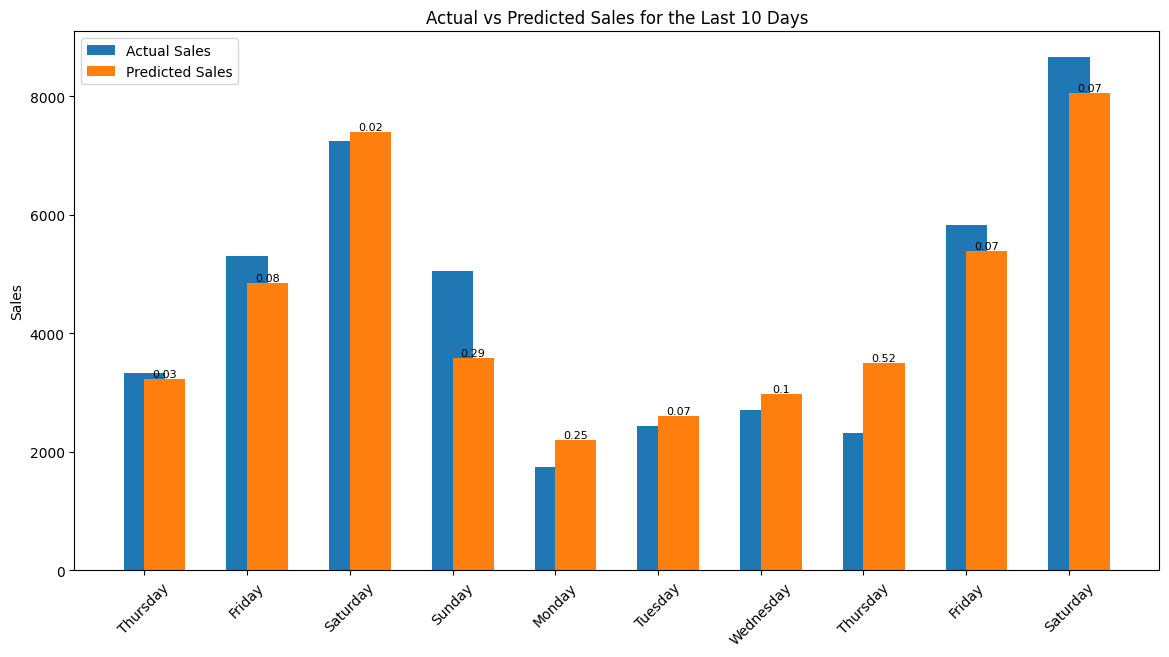

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error



daily_sales = original_df.resample('D', on='Date').sum().reset_index()
daily_sales['Total_Sales'] = daily_sales['Price']

train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales[:train_size], daily_sales[train_size:]

p = d = q = range(0, 3)
P = D = Q = range(0, 3)
seasonal_period = [7]

pdq = [(x, y, z) for x in p for y in d for z in q]
seasonal_pdq = [(x, y, z, s) for x in P for y in D for z in Q for s in seasonal_period]

best_rmse = float('inf')
best_order = None
best_seasonal_order = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train['Total_Sales'], order=param, seasonal_order=param_seasonal)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast(steps=len(test))
            rmse = np.sqrt(mean_squared_error(test['Total_Sales'], forecast))
            if rmse < best_rmse:
                best_rmse = rmse
                best_order = param
                best_seasonal_order = param_seasonal
            print(f'SARIMA{param}x{param_seasonal} - RMSE: {rmse}')
        except:
            continue

print(f'Best SARIMA{best_order}x{best_seasonal_order} - RMSE: {best_rmse}')

best_model = SARIMAX(train['Total_Sales'], order=best_order, seasonal_order=best_seasonal_order)
best_model_fit = best_model.fit(disp=False)

forecast = best_model_fit.forecast(steps=len(test))
actual_10_days = test['Total_Sales'][-10:].values
predicted_10_days = forecast[-10:]


relative_errors = np.abs((actual_10_days - predicted_10_days) / actual_10_days)


prediction_df = pd.DataFrame({
    'Date': test['Date'][-10:],
    'Actual Sales': actual_10_days,
    'Predicted Sales': predicted_10_days,
    'Relative Error': relative_errors
})


print(prediction_df)

plt.figure(figsize=(14, 7))
bars1 = plt.bar(prediction_df['Date'], prediction_df['Actual Sales'], width=0.4, align='center', label='Actual Sales')
bars2 = plt.bar(prediction_df['Date'], prediction_df['Predicted Sales'], width=0.4, align='edge', label='Predicted Sales')



for bar, error in zip(bars2, prediction_df['Relative Error']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f"{round(error, 2)}", ha='center', va='bottom', fontsize=8)

plt.ylabel('Sales')
plt.title('Actual vs Predicted Sales for the Last 10 Days')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%A'))

plt.grid(False)
plt.gca().set_facecolor('none')

plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



          Date  Actual Sales  ARIMA Predicted Sales  SARIMA Predicted Sales  \
176 2023-03-26       5056.25            4489.616798             3814.817658   
177 2023-03-27       1749.09            2649.924530             2467.912787   
178 2023-03-28       2436.75            3672.590462             2810.566325   
179 2023-03-29       2698.44            3724.140624             2971.382767   
180 2023-03-30       2311.61            3245.798827             3462.953274   
181 2023-03-31       5819.69            5423.186928             5201.074768   
182 2023-04-01       8658.18            6879.720328             7795.953527   

     ARIMA Relative Error  SARIMA Relative Error  
176              0.112066               0.245524  
177              0.515030               0.410970  
178              0.507168               0.153408  
179              0.380109               0.101148  
180              0.404129               0.498070  
181              0.068131               0.106297  
182       

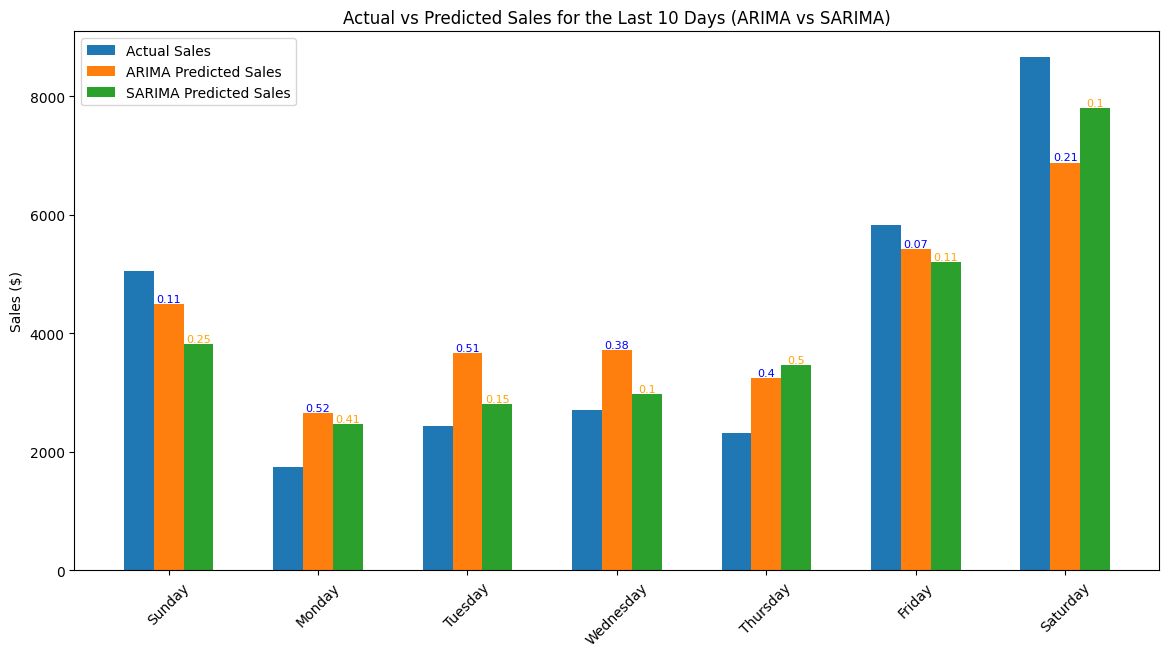

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

daily_sales = original_df.resample('D', on='Date').sum().reset_index()
daily_sales['Total_Sales'] = daily_sales['Price']

train_size = int(len(daily_sales) * 0.8)
train, test = daily_sales[:train_size], daily_sales[train_size:]

arima_order = (5, 0, 4)
arima_model = ARIMA(train['Total_Sales'], order=arima_order)
arima_model_fit = arima_model.fit()

arima_forecast = arima_model_fit.forecast(steps=len(test))
arima_predicted_10_days = arima_forecast[-7:]

sarima_order = (2, 0, 2)
sarima_seasonal_order = (1, 1, 2, 7)
sarima_model = SARIMAX(train['Total_Sales'], order=sarima_order, seasonal_order=sarima_seasonal_order)
sarima_model_fit = sarima_model.fit(disp=False)

sarima_forecast = sarima_model_fit.forecast(steps=len(test))
sarima_predicted_10_days = sarima_forecast[-7:]

actual_10_days = test['Total_Sales'][-7:].values

arima_relative_errors = np.abs((actual_10_days - arima_predicted_10_days) / actual_10_days)
sarima_relative_errors = np.abs((actual_10_days - sarima_predicted_10_days) / actual_10_days)

prediction_df = pd.DataFrame({
    'Date': test['Date'][-7:],
    'Actual Sales': actual_10_days,
    'ARIMA Predicted Sales': arima_predicted_10_days,
    'SARIMA Predicted Sales': sarima_predicted_10_days,
    'ARIMA Relative Error': arima_relative_errors,
    'SARIMA Relative Error': sarima_relative_errors
})

print(prediction_df)

plt.figure(figsize=(14, 7))
bars_actual = plt.bar(prediction_df['Date'] - pd.Timedelta(days=0.2), prediction_df['Actual Sales'], width=0.2, align='center', label='Actual Sales')
bars_arima = plt.bar(prediction_df['Date'], prediction_df['ARIMA Predicted Sales'], width=0.2, align='center', label='ARIMA Predicted Sales')
bars_sarima = plt.bar(prediction_df['Date'] + pd.Timedelta(days=0.2), prediction_df['SARIMA Predicted Sales'], width=0.2, align='center', label='SARIMA Predicted Sales')

for bar, error in zip(bars_arima, prediction_df['ARIMA Relative Error']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f"{round(error, 2)}", ha='center', va='bottom', fontsize=8, color='blue')

for bar, error in zip(bars_sarima, prediction_df['SARIMA Relative Error']):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f"{round(error, 2)}", ha='center', va='bottom', fontsize=8, color='orange')

plt.ylabel('Sales ($)')
plt.title('Actual vs Predicted Sales for the Last 10 Days (ARIMA vs SARIMA)')
plt.legend()
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%A'))
plt.grid(False)
plt.gca().set_facecolor('None')

plt.show()


# Itemized Analysis

### Identifying stationarity on Data

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, significance_level=0.05):
    # This returns a list with adf statistic (float), p-value (float), usedlag(int), nobs(int), critical values (dict),icbest(fl
    result = adfuller(series)
    # We take the p value
    p_value = result[1]
    # Returns true for stationary data
    return p_value < significance_level

# This function will differentiate the data until it is stationary (if the number of dif is smaller than 3)
def check_d_arima(series):
    n_dif=0
    stationarity = adf_test(series)
    while stationarity == False and n_dif<3:
        series_diff=series.diff().dropna()
        stationarity=adf_test(series_diff)
        n_dif=n_dif+1
    return n_dif

# Create a dictionary of itmes wih d paramter ARIMA(p,d,q) if the item has at least 100 data points
d={}
for category in categories:
    if len(df_hourly_dict[category]) > 100:
        n=check_d_arima(df_hourly_dict[category]['Quantity'])
        d[category]=n

### Plots on stationarity

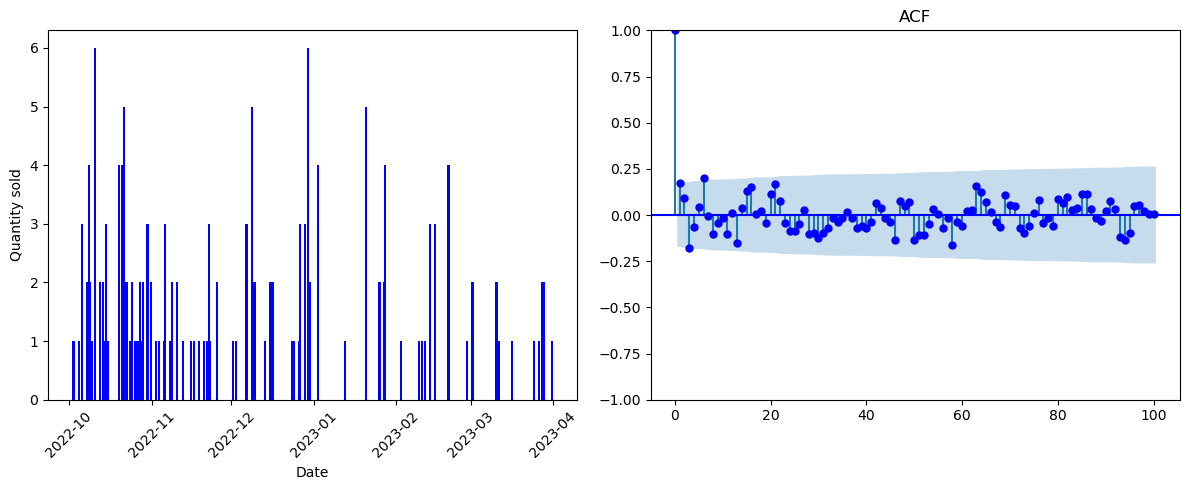

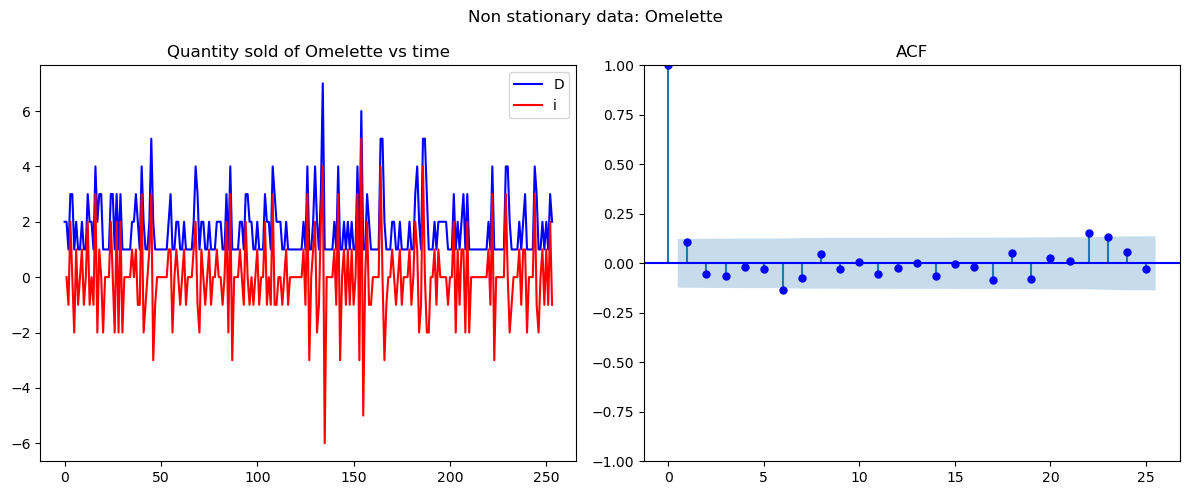

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# For example Tiramisu is non-stationary (needs one diff) and omelette is stationary

name='Happy Hour Wine'

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
#bins=bins = pd.date_range(start=df_hourly_dict[name]['Date'].min().floor('D'), end=df_hourly_dict[name]['Date'].max().ceil('D'), freq='D')
#axs[0].hist(df_hourly_dict[name]['Quantity'], bins=bins, alpha=0.7, color='blue')
axs[0].bar(df_hourly_dict[name]['Date'], df_hourly_dict[name]['Quantity'], color='Blue')
axs[0].set_ylabel('Quantity sold')
axs[0].tick_params(axis='x', rotation=45)
axs[0].set_xlabel('Date')

# Plotting data on the second subplot
plot_acf(df_hourly_dict[name]['Quantity'], ax=axs[1],color='blue',lags=100)
axs[1].set_title('ACF')

#plt.suptitle(f'Stationary data: {name}')
plt.tight_layout()
plt.gcf().set_facecolor('none')
plt.show()

name='Omelette'

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plt.title('Omelette')
axs[0].plot(df_hourly_dict[name]['Quantity'], color='blue')
axs[0].legend('Data')
axs[0].plot(df_hourly_dict[name]['Quantity'].diff().dropna(), color='red')
axs[0].legend('Differentiated Data')
axs[0].set_title(f'Quantity sold of {name} vs time')

# Plotting data on the second subplot
plot_acf(df_hourly_dict[name]['Quantity'], ax=axs[1],color='blue')
#plot_acf(df_hourly_dict[name]['Quantity'].diff().dropna(), ax=axs[1],color='red')
axs[1].set_title('ACF')

plt.suptitle(f'Non stationary data: {name}')
plt.tight_layout()
plt.show()

### ARIMA tests

Number of test points: 25
best ARIMA model (p,d,q) = ( 1, 1, 3 )
Average cv mase of 0.757
Predicted weekly sales of Pappardelle al Sugo di Carne =  234.23999999999998
Actual weekly sales of Pappardelle al Sugo di Carne =  215.2800106871434
Relative errror (%) 8.094257732606122
--------------------------------------------------------------


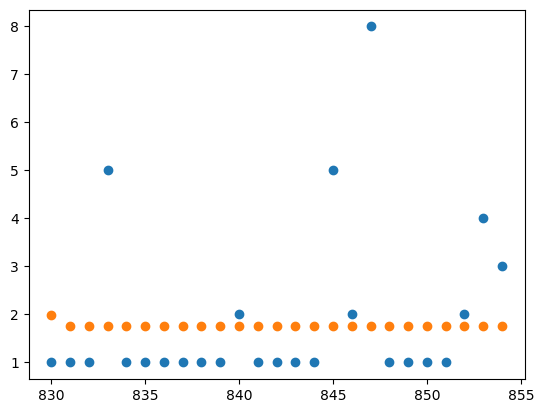

Number of test points: 10
best ARIMA model (p,d,q) = ( 3, 1, 3 )
Average cv mase of 0.754
Predicted weekly sales of Tortelli di Zucca =  168.0
Actual weekly sales of Tortelli di Zucca =  166.75002890753095
Relative errror (%) 0.7440304121839603
--------------------------------------------------------------


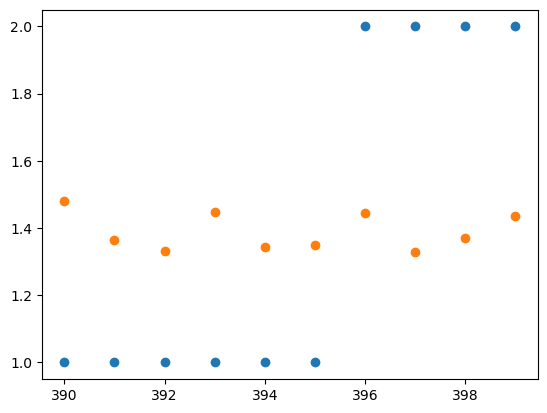

Number of test points: 17
best ARIMA model (p,d,q) = ( 1, 1, 1 )
Average cv mase of 1.017
Predicted weekly sales of Spaghetti Pesto =  201.70588235294116
Actual weekly sales of Spaghetti Pesto =  188.55523811578706
Relative errror (%) 6.5197128034884715
--------------------------------------------------------------


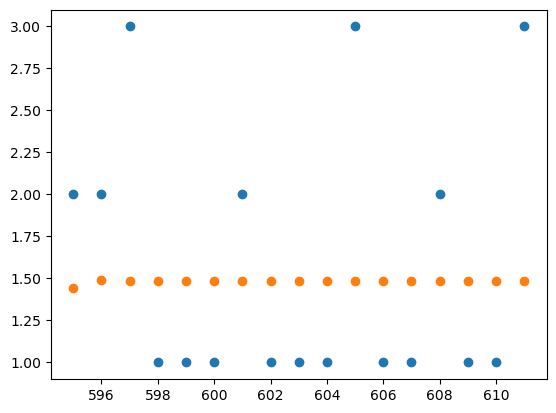

Number of test points: 17
best ARIMA model (p,d,q) = ( 2, 1, 3 )
Average cv mase of 0.73
Predicted weekly sales of Gnocchi ai Funghi =  188.1176470588235
Actual weekly sales of Gnocchi ai Funghi =  217.41165959177238
Relative errror (%) 15.57217676860947
--------------------------------------------------------------


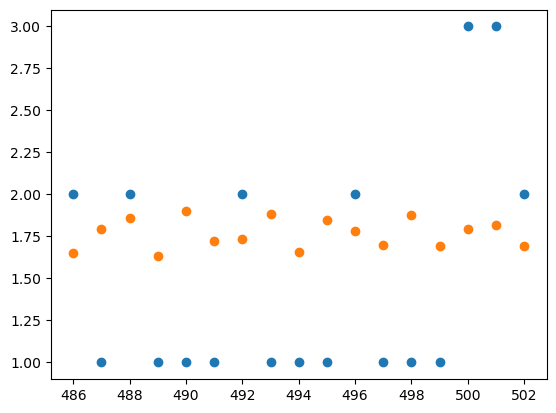

Number of test points: 6
best ARIMA model (p,d,q) = ( 2, 1, 3 )
Average cv mase of 0.84
Predicted weekly sales of Omelette =  133.83333333333331
Actual weekly sales of Omelette =  126.15945850181788
Relative errror (%) 5.73390398369771
--------------------------------------------------------------


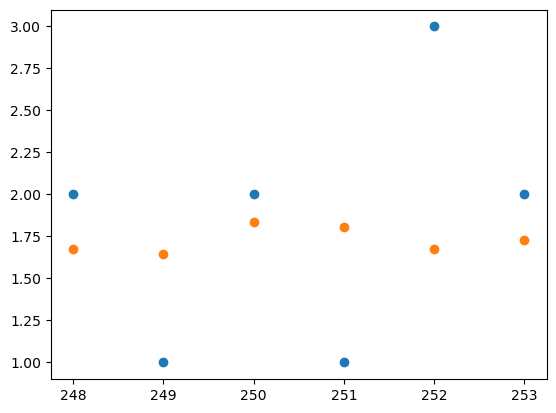

Number of test points: 10
best ARIMA model (p,d,q) = ( 2, 1, 2 )
Average cv mase of 0.876
Predicted weekly sales of Aperol Spritz =  98.7
Actual weekly sales of Aperol Spritz =  90.54634304546856
Relative errror (%) 8.261050612493861
--------------------------------------------------------------


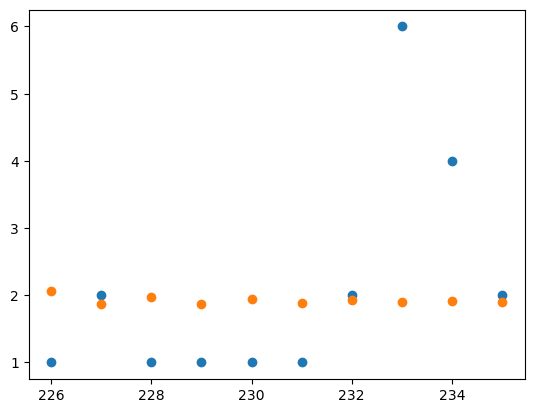

Number of test points: 8
best ARIMA model (p,d,q) = ( 3, 1, 1 )
Average cv mase of 0.856
Predicted weekly sales of Latte =  196.625
Actual weekly sales of Latte =  228.72130411985145
Relative errror (%) 16.323613029803663
--------------------------------------------------------------


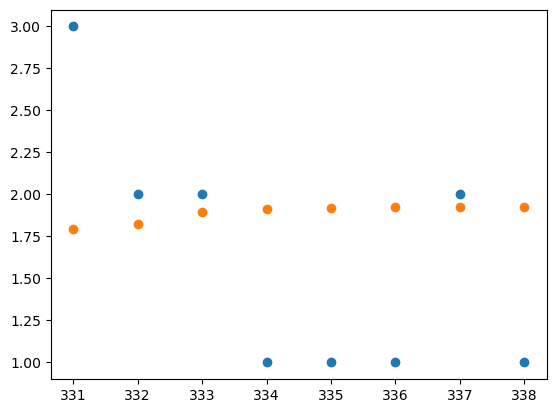

Number of test points: 5
best ARIMA model (p,d,q) = ( 2, 1, 3 )
Average cv mase of 0.907
Predicted weekly sales of Panna Cotta =  120.0
Actual weekly sales of Panna Cotta =  140.0524304262988
Relative errror (%) 16.710358688582332
--------------------------------------------------------------


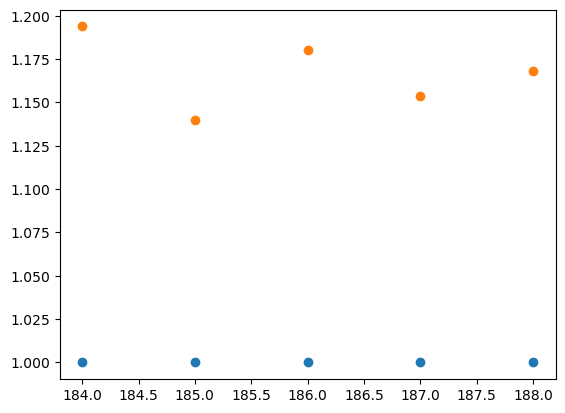

Number of test points: 7
best ARIMA model (p,d,q) = ( 2, 1, 3 )
Average cv mase of 0.976
Predicted weekly sales of Coke =  123.42857142857144
Actual weekly sales of Coke =  135.71453863738424
Relative errror (%) 9.953908618251104
--------------------------------------------------------------


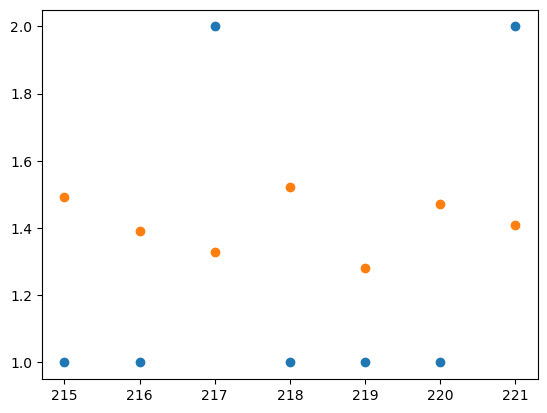

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.api import ARIMA

def mase(y_train, y_test, y_preds):
    n = len(y_train)
    m = len(y_test)
    denom = 0
    for i in range(n-m):
        denom += np.abs(y_train[i+1:i+m+1] - y_train[i]*np.ones(m)).mean()
    denom = denom / (n-m)
    num = np.abs(y_test - y_preds).mean()
    return num/denom

total_values=[]
total_predictions=[]

# Selecting some items to try the model
probar=['Pappardelle al Sugo di Carne','Tortelli di Zucca','Spaghetti Pesto','Gnocchi ai Funghi','Omelette','Aperol Spritz','Latte','Panna Cotta','Coke']

n_range=4

for probar in probar:

    item_name=probar

    # last week worth of data aside for testing
    value=len(df_hourly_dict[item_name][df_hourly_dict[item_name]['Week']==df_hourly_dict[item_name]['Week'].values[-1]])

    print('Number of test points:', value)

    df_train = df_hourly_dict[item_name].iloc[:-value].copy()
    df_test = df_hourly_dict[item_name].drop(df_train.index).copy()


    dif=df_test['Date'].iloc[-1]-df_test['Date'].iloc[0]
    hours=dif.total_seconds()/3600

    cv=TimeSeriesSplit(n_splits=10,test_size=10)

    arima_mase=np.zeros((10,n_range,n_range))

    i=0
    for train_index, test_index in cv.split(df_train):
        df_tt=df_train.iloc[train_index]
        df_ho=df_train.iloc[test_index]

        j = 0
        for p in range(n_range):
            k = 0
            for q in range(n_range):
                #arima = ARIMA(df_tt['Quantity'].values,
                #                  order=(p, d['Aperol Spritz'], q)).fit()
                model=ARIMA(df_tt['Quantity'].values,
                                order=(p, d[item_name], q))
                #arima=model.fit(method='innovations_mle')
                arima=model.fit(method='innovations_mle')
                arima_mase[i,j,k] = mase(df_tt['Quantity'].values, df_ho['Quantity'].values,  arima.forecast(len(df_ho)))
                k = k +1
            j = j + 1
        i = i +1

    arima_ind = np.unravel_index(np.argmin(np.mean(arima_mase, axis=0), axis=None),
                                np.mean(arima_mase, axis=0).shape)
    np.unravel_index(np.argmin(np.mean(arima_mase, axis=0), axis=None),
                    np.mean(arima_mase, axis=0).shape)

    print("best ARIMA model",
            "(p,d,q) = ( %s, %s, %s )" %(range(n_range)[arima_ind[0]], 1, range(n_range)[arima_ind[1]]))

    print("Average cv mase of",
            np.round(np.mean(arima_mase, axis=0)[arima_ind],3))


    model=ARIMA(df_hourly_dict[item_name]['Quantity'],order=(range(n_range)[arima_ind[0]], 1, range(n_range)[arima_ind[1]])).fit()

    steps=value
    forecast = model.get_forecast(steps=steps)
    forecast_values = forecast.predicted_mean
    forecast_conf_int = forecast.conf_int()
    forecast_index = np.arange(len(df_train), len(df_train) + steps)

    mean=df_test['Quantity'].mean()*hours
    pred_mean=forecast_values.mean()*hours

    total_predictions.append(mean)
    total_values.append(pred_mean)

    print(f'Predicted weekly sales of {item_name} = ', mean)
    print(f'Actual weekly sales of {item_name} = ', pred_mean)
    print('Relative errror (%)',np.abs(mean-pred_mean)/mean*100)
    print("--------------------------------------------------------------")
    plt.scatter(df_test.index,df_test['Quantity'])
    plt.scatter(df_test.index,forecast_values)
    plt.show()

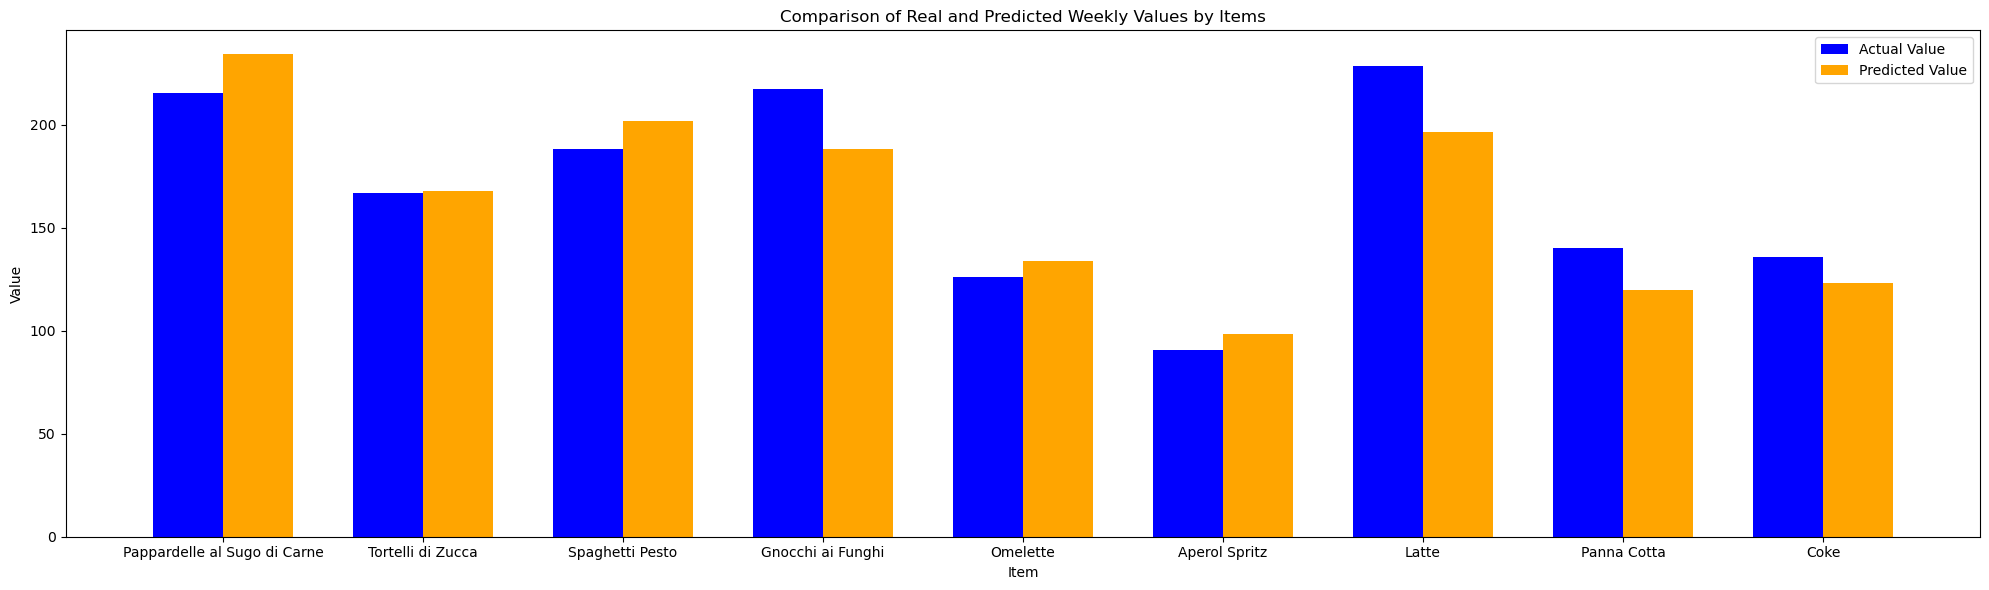

In [ ]:
real_values = total_values
predicted_values = total_predictions
categories=['Pappardelle al Sugo di Carne','Tortelli di Zucca','Spaghetti Pesto','Gnocchi ai Funghi','Omelette','Aperol Spritz','Latte','Panna Cotta','Coke']
# Set up the bar plot
fig, ax = plt.subplots(figsize=(20, 6),facecolor='none')
bar_width = 0.35
index = np.arange(len(categories))

# Plot bars
rects1 = ax.bar(index, real_values, bar_width, label='Actual Value', color='blue')
rects2 = ax.bar(index + bar_width, predicted_values, bar_width, label='Predicted Value', color='orange')

# Add labels, title, and legend
ax.set_xlabel('Item')
ax.set_ylabel('Value')
ax.set_title('Comparison of Real and Predicted Weekly Values by Items')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(categories)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

